# 0.0 IMPORTS

In [53]:
import pandas     as pd
import numpy      as np
import seaborn    as sns
import scikitplot as skplt


import matplotlib.gridspec as gridspec

from matplotlib import pyplot as plt
from scipy      import stats  as ss

from random               import sample
from IPython.core.display import HTML
from IPython.display      import Image

from boruta                  import BorutaPy
from xgboost                 import XGBClassifier
from lightgbm                import LGBMClassifier
from catboost                import CatBoostClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import RandomForestRegressor, ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from category_encoders       import TargetEncoder
from feature_engine.encoding import CountFrequencyEncoder

## 0.1 Helper functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

    
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return  np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))


# compute precision at k
def precision_at_k(data, yhat, k=20000):
    # propensity score
    data['score'] = yhat[:,1].tolist()

    # sort clients by propensity score
    data = data.sort_values('score', ascending=False)

    #reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum()/data['ranking']

    return data.loc[k, 'precision_at_k']


def recall_at_k(data, yhat, k=20000):
    # propensity score
    data['score'] = yhat[:,1].tolist()

    # sort clients by propensity score
    data = data.sort_values('score', ascending=False)

    #reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum()/data['response'].sum()

    return data.loc[k, 'recall_at_k']


def cross_validation(model, kfold, X_train, y_train):
    precision_list = []
    recall_list = []
    skf = StratifiedKFold(n_splits=kfold)

    for train, test in skf.split(X_train, y_train):
        # test dataset
        X_train_fold = X_train.iloc[train]
        y_train_fold = y_train.iloc[train]

        # validation dataset
        X_test_fold = X_train.iloc[test]
        y_test_fold = y_train.iloc[test]

        # Encoding
        ss = StandardScaler()

        # annual_premium
        X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
        
        mms_age = MinMaxScaler()
        mms_vintage = MinMaxScaler()

        # age (since its distribution is not a normal one)
        X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)

        # vintage
        X_train_fold['vintage'] = mms_vintage.fit_transform(X_train_fold[['vintage']].values)
        
        # gender
        le = LabelEncoder()
        X_train_fold['gender'] = le.fit_transform(X_train_fold['gender'])

        # region_code - Target Enconder
        te = TargetEncoder()
        X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
        X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)

        # vehicle_age - Ordinal Encoding
        vehicle_age_dict = {'below_1_year': 1, 'between_1_2_years': 2, 'over_2_years': 3}
        X_train_fold['vehicle_age'] = X_train_fold['vehicle_age'].map(vehicle_age_dict)

        # policy_sales_channel - Frequency Encoding
        X_train_fold['policy_sales_channel'] = X_train_fold['policy_sales_channel'].astype(str)
        cfe = CountFrequencyEncoder(encoding_method='frequency', variables=['policy_sales_channel'])
        X_train_fold = cfe.fit_transform(X_train_fold)
        
        # annual_premium
        X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)

        # age (since its distribution is not a normal one)
        X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)

        # vintage
        X_test_fold['vintage'] = mms_vintage.transform(X_test_fold[['vintage']].values)

        # gender
        X_test_fold['gender'] = le.transform(X_test_fold['gender'])

        # region_code - Target Enconder
        X_test_fold['region_code'] = X_test_fold['region_code'].astype(str)
        X_test_fold['region_code'] = te.transform(X_test_fold['region_code'])

        # vehicle_age - Ordinal Encoding
        vehicle_age_dict = {'below_1_year': 1, 'between_1_2_years': 2, 'over_2_years': 3}
        X_test_fold['vehicle_age'] = X_test_fold['vehicle_age'].map(vehicle_age_dict)

        # policy_sales_channel - Frequency Encoding
        X_test_fold['policy_sales_channel'] = X_test_fold['policy_sales_channel'].astype(str)
        X_test_fold = cfe.transform(X_test_fold)
        X_test_fold = X_test_fold.replace(np.nan, 0)
        
        cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage',
                         'policy_sales_channel', 'previously_insured']
        
        X_train_fold = X_train_fold[cols_selected]
        X_test_fold = X_test_fold[cols_selected]

        # Model training
        model.fit(X_train_fold, y_train_fold)

        # Predicting probability
        yhat = model.predict_proba(X_test_fold)

        df = X_test_fold.copy()
        df['response'] = y_test_fold.copy()

        precision_list.append(precision_at_k(df, yhat))
        recall_list.append(recall_at_k(df, yhat))

    return pd.DataFrame({'Model': type(model).__name__,
                       'Precision at k': np.round(np.mean(precision_list), 4).astype(str) + '+/-' +
                         np.round(np.std(precision_list), 4).astype(str),
                       'Recall at k': np.round(np.mean(recall_list), 4).astype(str) + '+/-' +
                         np.round(np.std(recall_list), 4).astype(str)}, index=[0])


In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Loading dataset

In [4]:
data_raw = pd.read_csv('../data/raw/train.csv')

In [5]:
data_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0 ANÁLISE DESCRITIVA

In [6]:
df1 = data_raw.copy()

In [7]:
# columns in snakecase
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code',
            'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
            'policy_sales_channel', 'vintage', 'response']

df1.columns = cols_new

## 1.1 Data informations

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   driving_license       381109 non-null  int64  
 4   region_code           381109 non-null  float64
 5   previously_insured    381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   annual_premium        381109 non-null  float64
 9   policy_sales_channel  381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


## 1.2 Análise Descritiva

In [9]:
# numerical features
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

# categorical features
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.2.1 Atributos Numéricos

In [10]:
# Tendência Central - média, mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersão - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0 FEATURE ENGINEERING

In [11]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

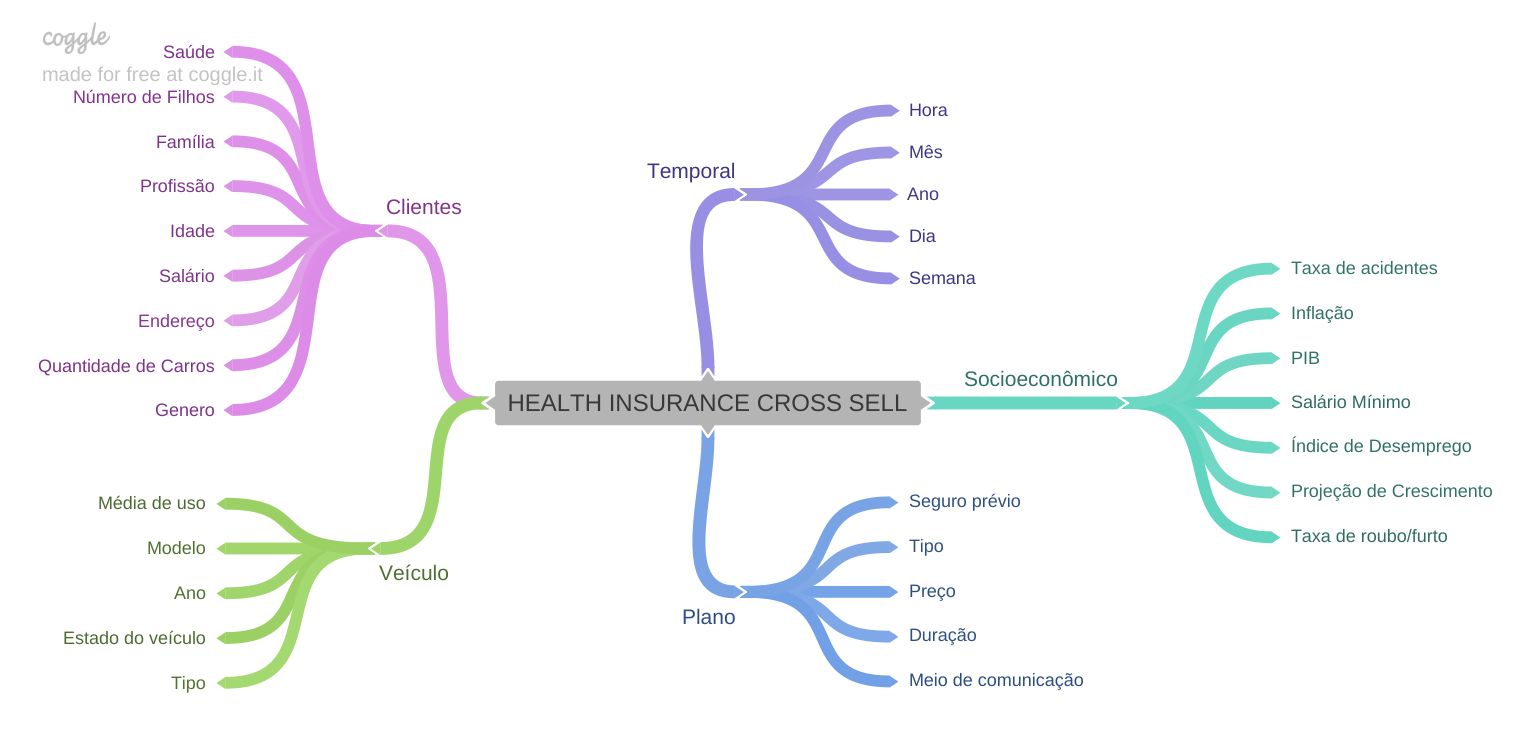

In [12]:
Image('../img/MindMap.png')

## 2.2 Criação de Hipóteses

### 2.2.1 Hipóteses Cliente

**1.** Clientes com mais de 40 anos são mais propensos a contratarem o seguro.

**2.** Clientes sem filhos são mais propensos a contratarem o seguro.

**3.** Clientes mulheres são mais propensas a contratarem o seguro.

**4.** Clientes com carteira de habilitação são mais propensos a contratarem o seguro.

### 2.2.2 Hipóteses Veículo

**1.** Clientes com veículo que apresenta algum dano são mais propensos a contratarem o seguro.

**2.** Clientes com veículos mais novos são mais propensos a contratarem o seguro.

**3.** Clientes que usam o veículo em mais dias da semana são mais propensos a contratarem o seguro.

### 2.2.3 Hipóteses Temporal

**1.** Clientes contatados no mês de janeiro são menos propensos a contratarem o seguro.

**2.** Clientes contatados na sexta-feira são menos propensos a contratarem o seguro.

**3.** Clientes contatados depois do meio dia são menos propensos a contratarem o seguro.

### 2.2.4 Hipóteses Plano

**1.** Clientes com annual premium maior são mais propensos a contratarem o seguro.

**2.** Clientes mais antigos são mais propensos a contratarem o seguro.

**3.** Clientes contatados por um determinado meio de comunicação são mais propensos a contratarem o seguro.

**4.** Clientes que já possuem seguro de veículo são menos propensos a contratarem o seguro.

### 2.2.5 Hipóteses Socioeconômico

**1.** Clientes que moram em regiões com maior taxa de acidentes são mais propensos a contratarem o seguro.

**2.** Clientes que moram em regiões com maior taxa de furto/roubo são mais propensos a contratarem o seguro.

**3.** Clientes que moram em regiões com menor índice de desemprego são mais propensos a contratarem o seguro.

## 2.3 Lista Final de Hipóteses

**1.** Clientes com mais de 40 anos são mais propensos a contratarem o seguro.

**2.** Clientes mulheres são mais propensas a contratarem o seguro.

**3.** Clientes com carteira de habilitação são mais propensos a contratarem o seguro.

**4.** Clientes com veículo que apresenta algum dano são mais propensos a contratarem o seguro.

**5.** Clientes com veículos mais novos são mais propensos a contratarem o seguro.

**6.** Clientes com planos mais caros são mais propensos a contratarem o seguro.

**7.** Clientes mais antigos são mais propensos a contratarem o seguro.

**8.** Clientes contatados por um determinado meio de comunicação são mais propensos a contratarem o seguro.

**9.** Clientes que já possuem seguro de veículo são menos propensos a contratarem o seguro.

**10.** Clientes que moram em regiões com maior taxa de acidentes são mais propensos a contratarem o seguro.

## 2.4 Feature Enginnering

In [13]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else
                                              'between_1_2_years' if x == '1-2 Year' else 'below_1_year')

# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3.0 FILTRAGEM DOS DADOS

In [14]:
df3 = df2.copy()

# 4.0 ANÁLISE EXPLORATÓRIA DOS DADOS

In [15]:
df4 = df3.copy()

## 4.1 Análise Univariada

### Variáveis Numéricas

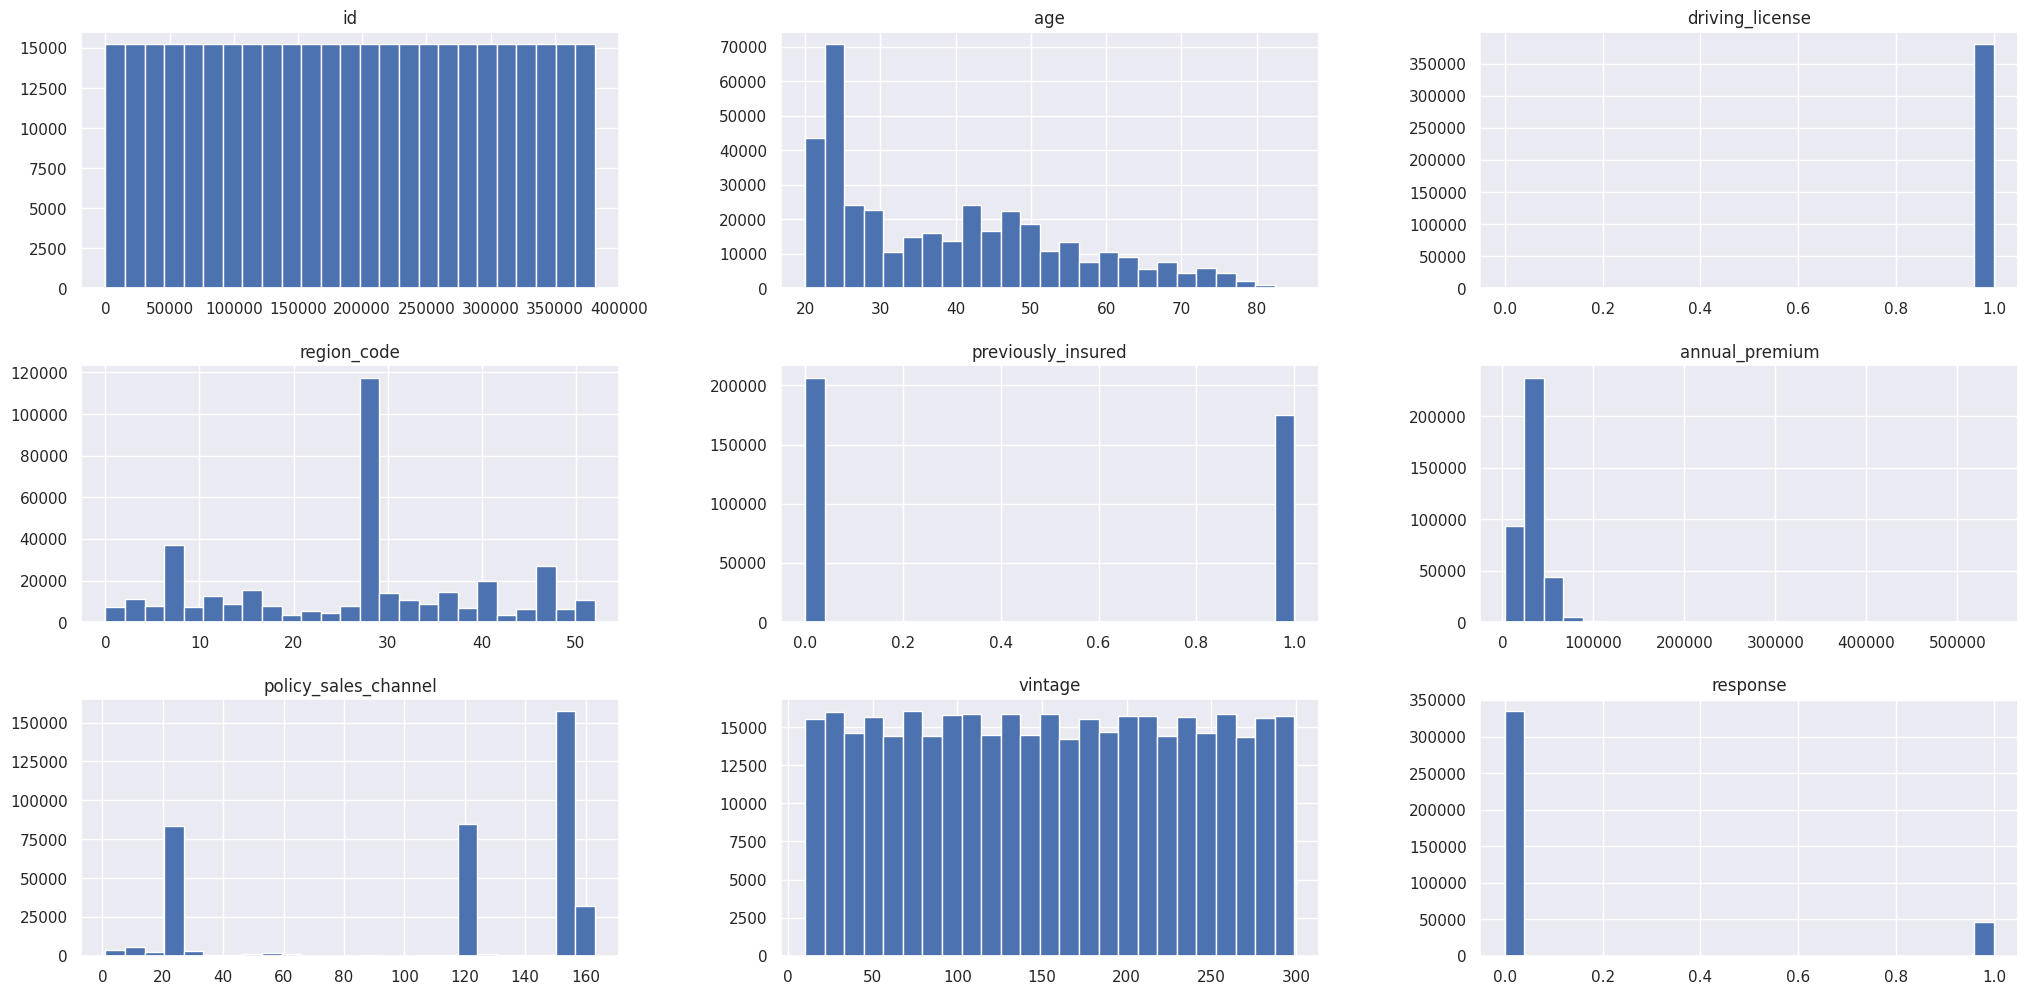

In [23]:
num_attributes.hist(bins=25);

### Variáveis Categóricas

## 4.2 Análise Bivariada

### H1. Clientes com mais de 40 anos são mais propensos a contratarem o seguro.
***VERDADEIRA.*** Clientes entre 40 e 50 anos são mais propensos a contratarem o seguro.

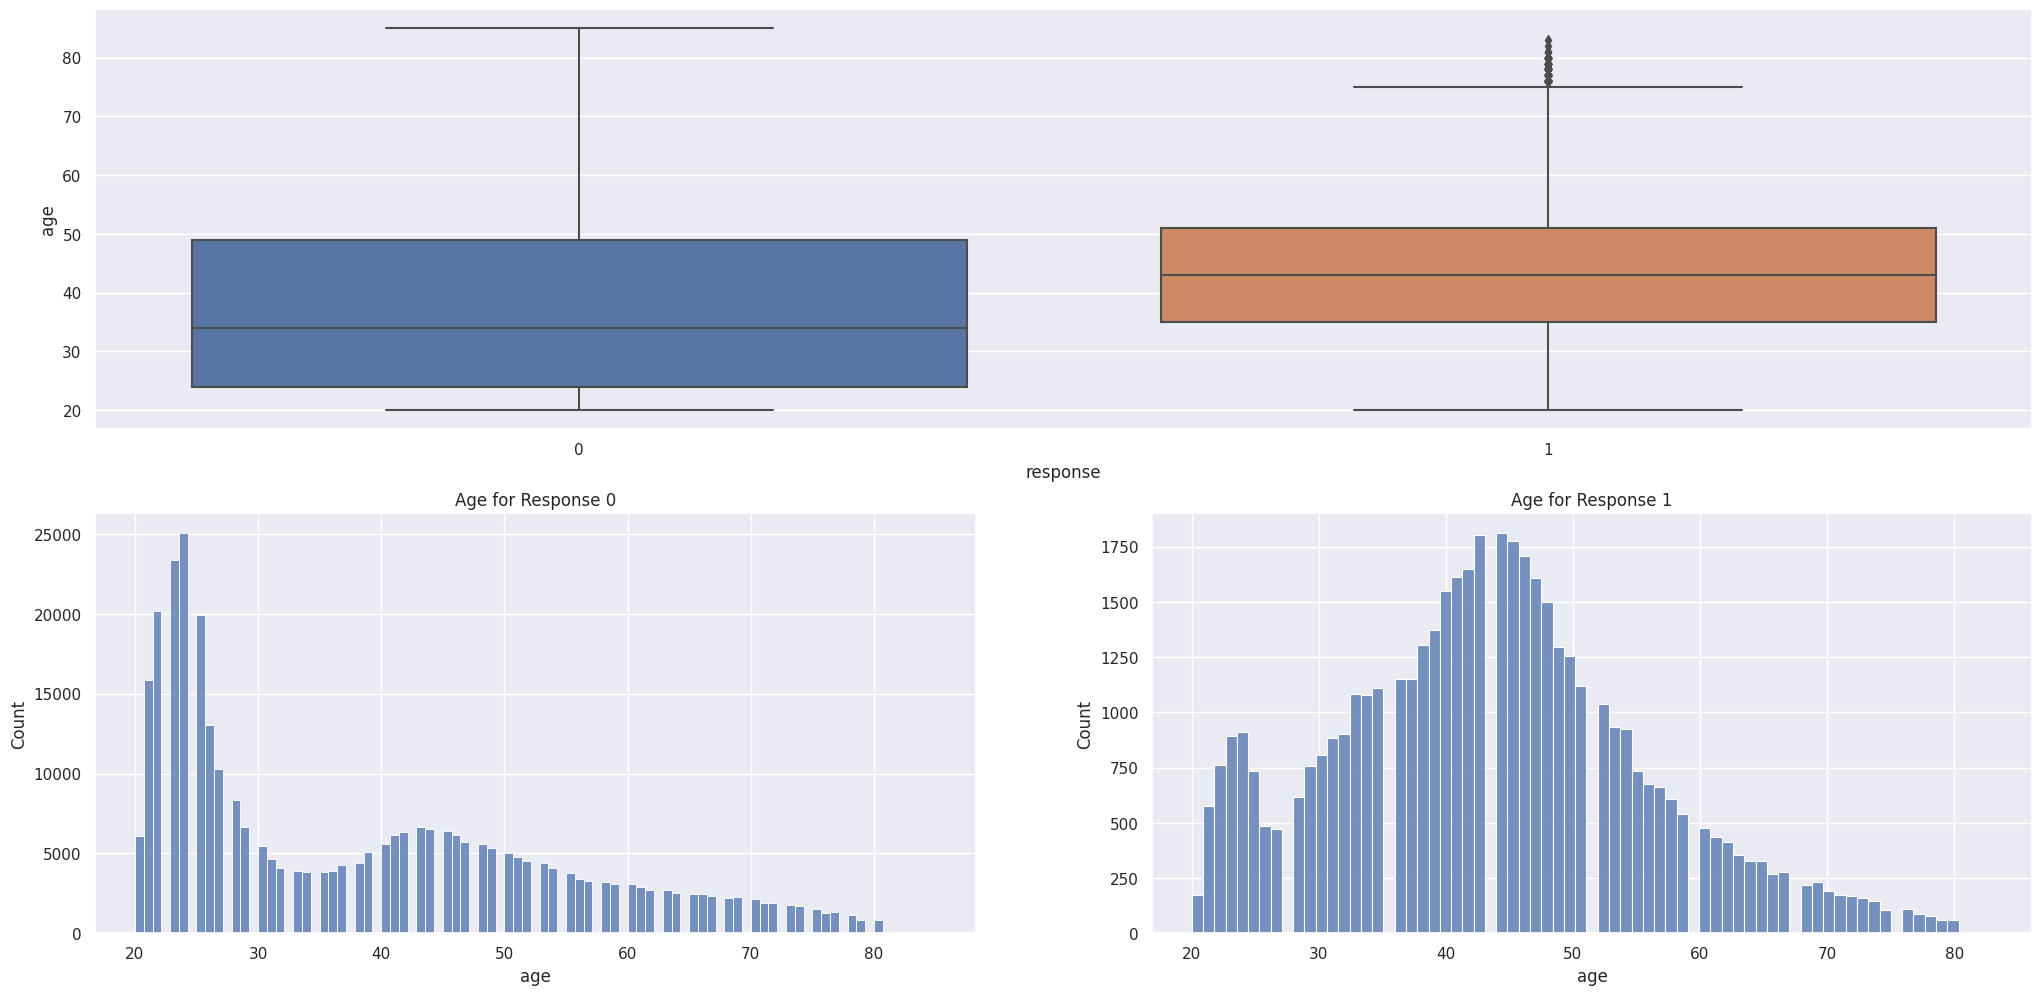

In [15]:
# 'age'
G = gridspec.GridSpec(2, 2)

ax1 = plt.subplot(G[0, :])
sns.boxplot(x='response', y='age', data=df4, ax=ax1)

ax2 = plt.subplot(G[1, 0])
sns.histplot(data=df4[df4['response'] == 0], x='age', ax=ax2)
plt.title('Age for Response 0')

ax3 = plt.subplot(G[1, 1])
sns.histplot(data=df4[df4['response'] == 1], x='age', ax=ax3)
plt.title('Age for Response 1');

### **H2.** Clientes mulheres são mais propensas a contratarem o seguro.
***FALSA.*** Clientes HOMENS são mais propensos a contratarem o seguro.

gender,Female,Male
response,,
0,0.469006,0.530994
1,0.389317,0.610683


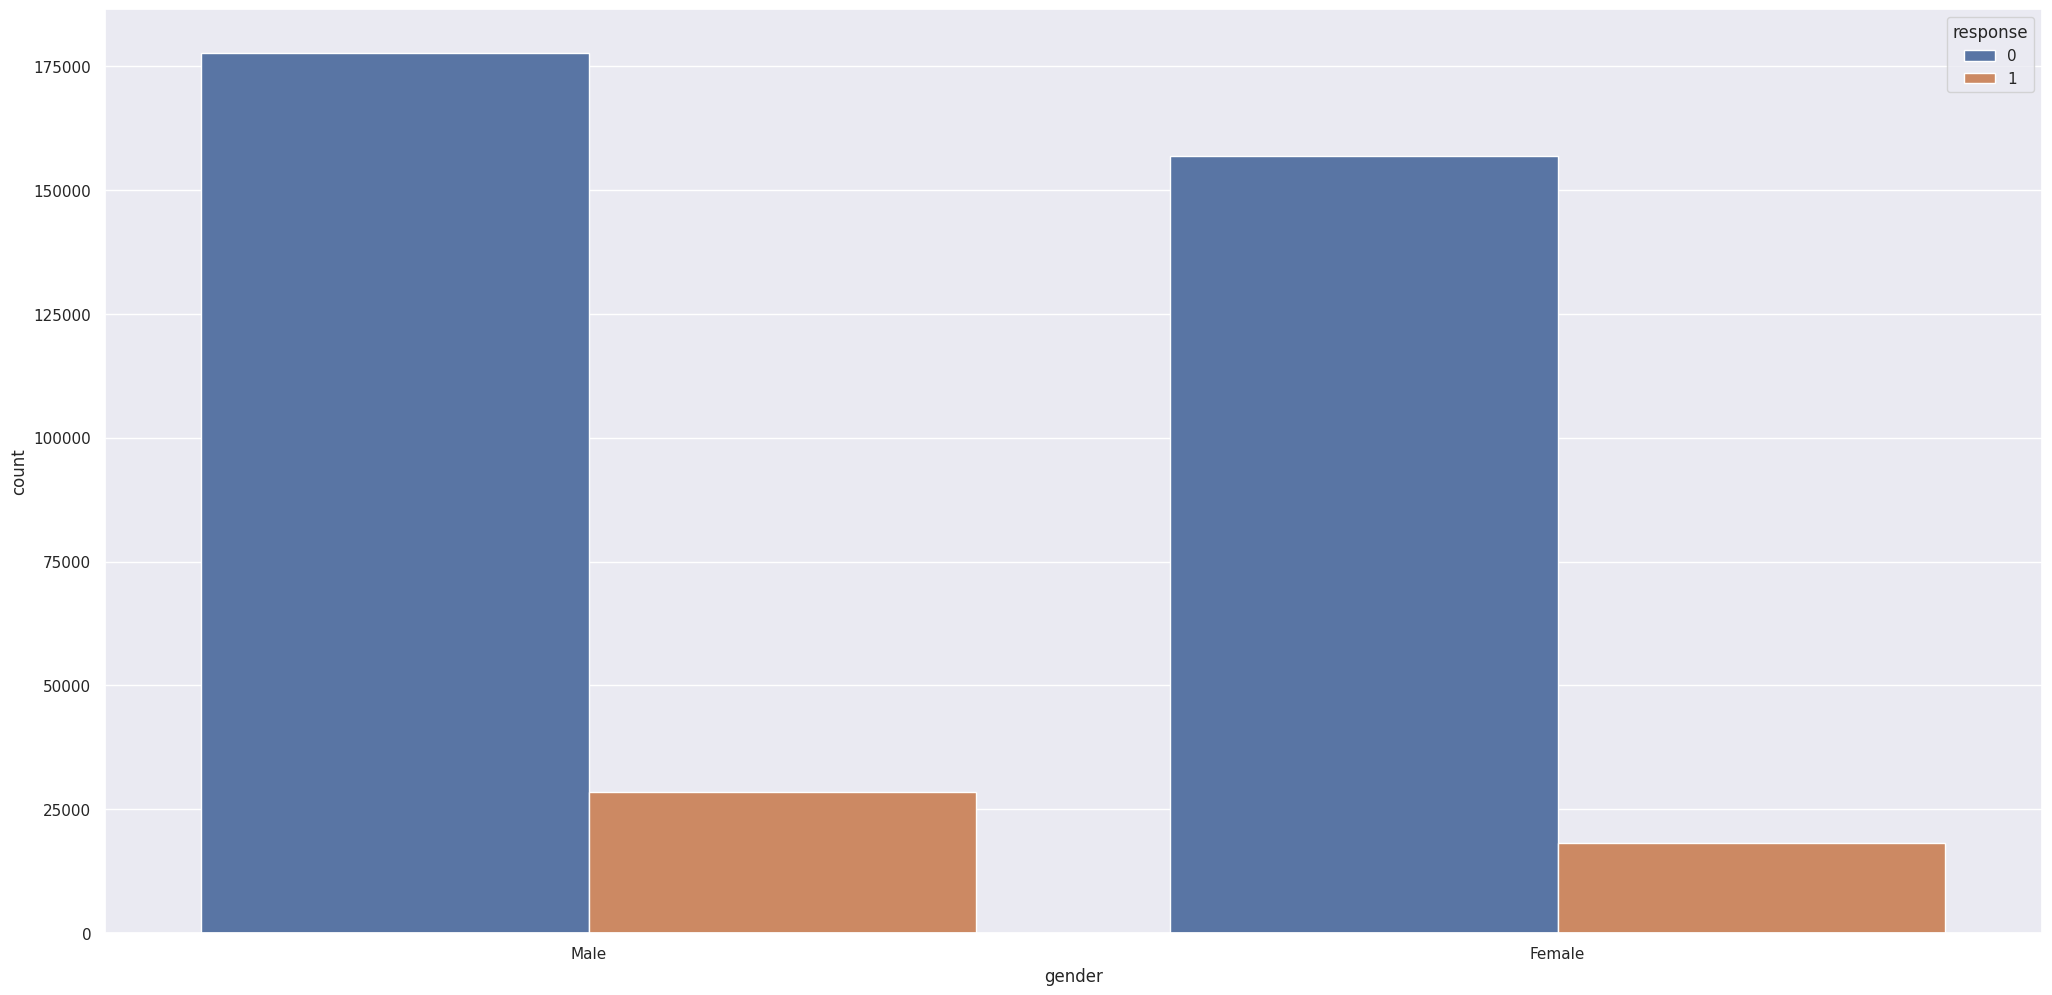

In [16]:
# 'gender'
sns.countplot(x=df4['gender'], hue=df4['response'])

pd.crosstab(df4['response'], df4['gender']).apply(lambda x: x/x.sum(), axis=1)

### **H3.** Clientes com carteira de habilitação são mais propensos a contratarem o seguro.
***VERDADEIRA.*** Clientes com CARTEIRA DE HABILITAÇÃO são mais propensos a contratarem o seguro.

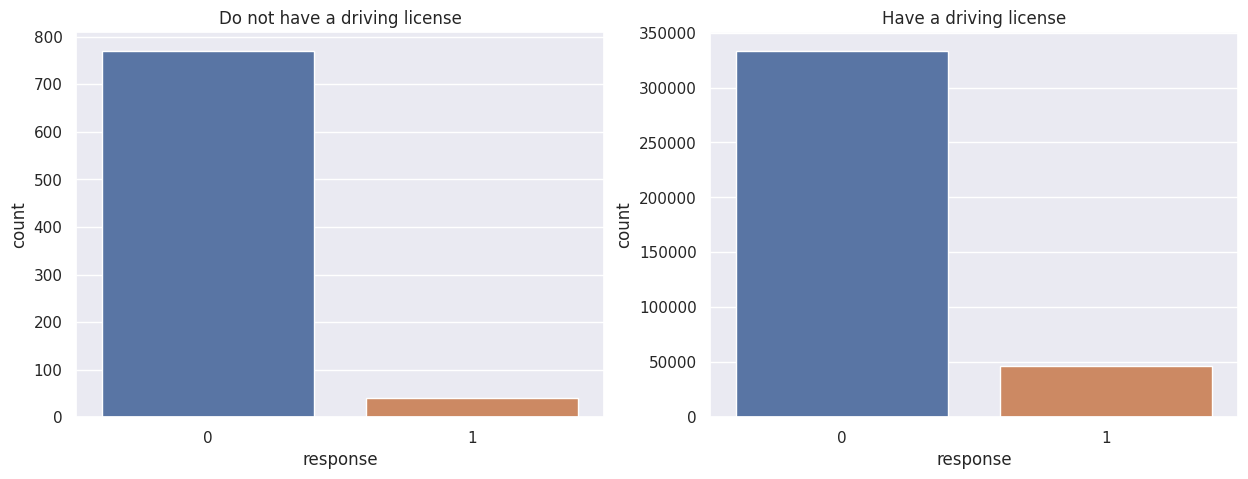

In [17]:
# 'driving_license'
plt.figure(figsize=(15, 5))
G = gridspec.GridSpec(1, 2)

ax1 = plt.subplot(G[0, 0])
sns.countplot(x='response', data=df4[df4['driving_license'] == 0], ax=ax1)
plt.title('Do not have a driving license')

ax2 = plt.subplot(G[0, 1])
sns.countplot(x='response', data=df4[df4['driving_license'] == 1], ax=ax2)
plt.title('Have a driving license');

### **H4.** Clientes com veículo que apresenta algum dano são mais propensos a contratarem o seguro.
***VERDADEIRA.*** Clientes com veículos que aprensentam algum DANO são mais propensos a contratarem o seguro.

response,0,1
vehicle_damage,,
0,0.994796,0.005204
1,0.762345,0.237655


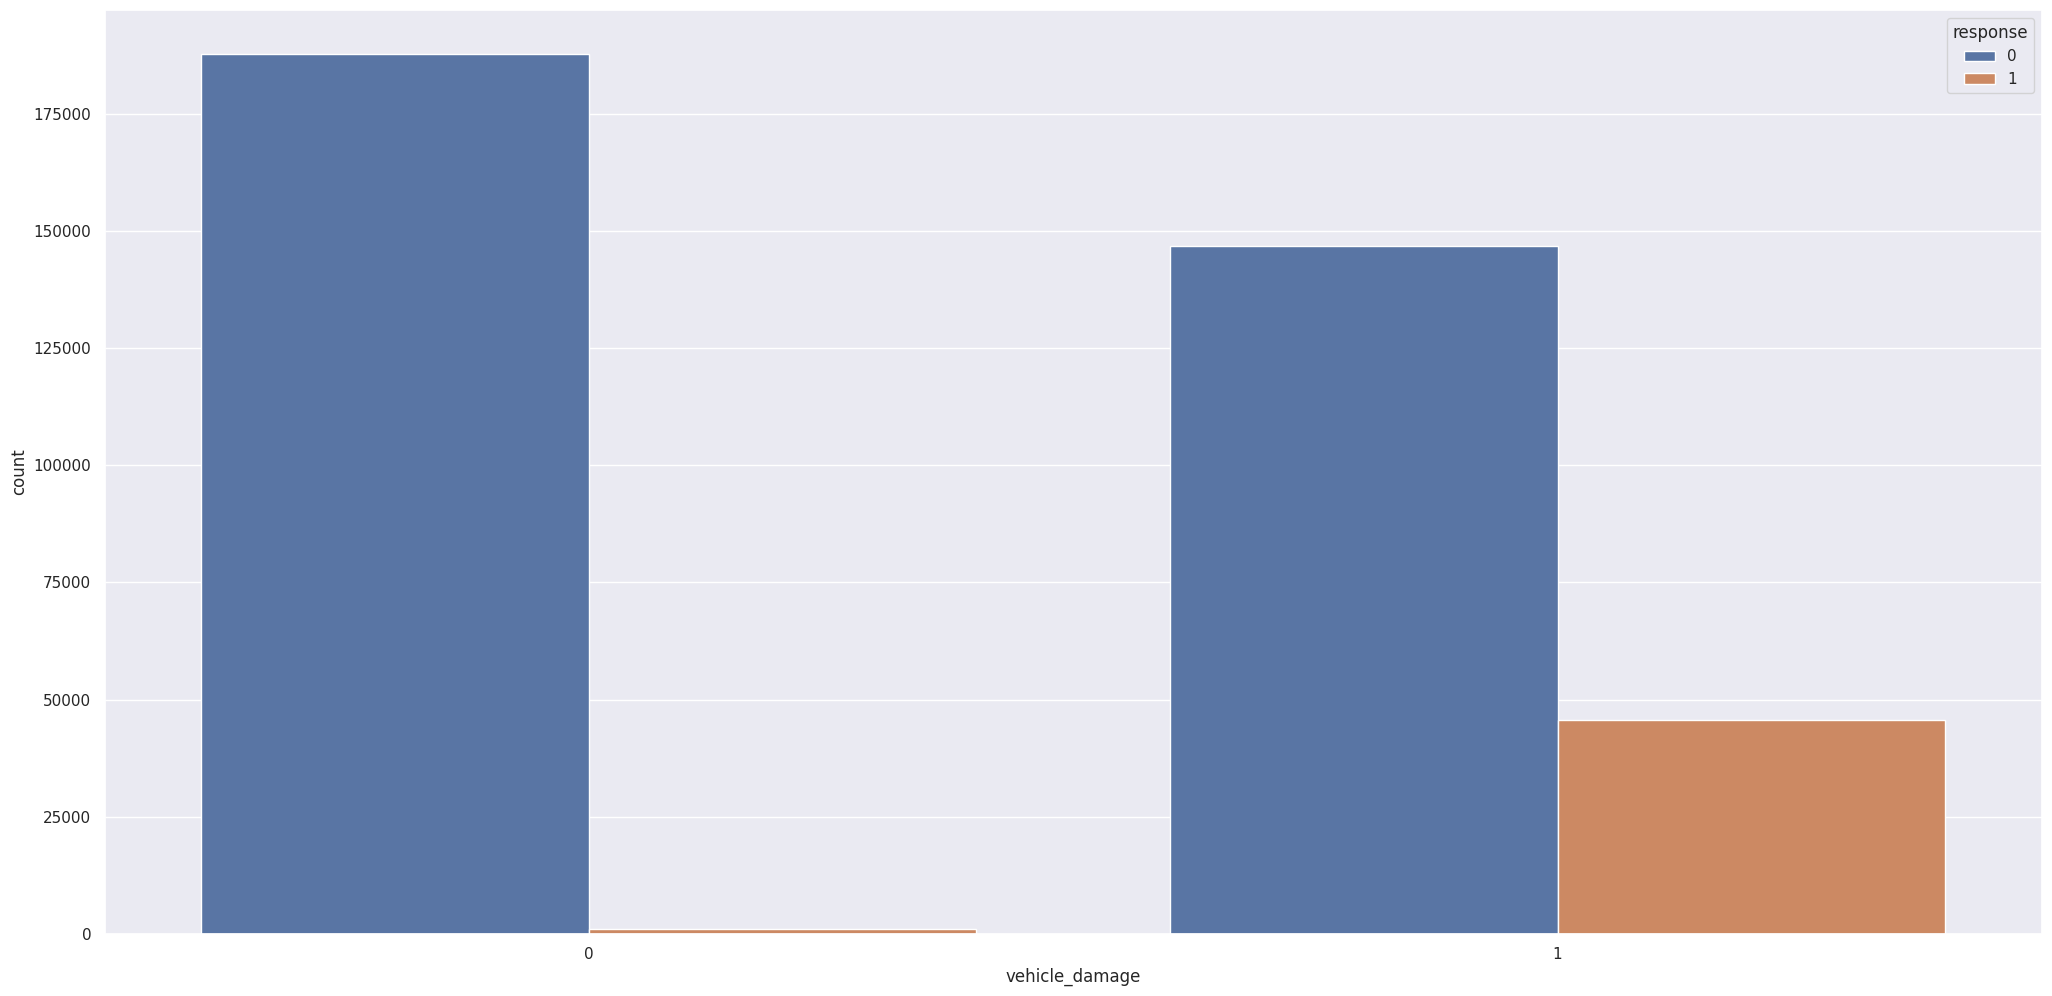

In [21]:
# 'vehicle_damage'
sns.countplot(x=df4['vehicle_damage'], hue=df4['response'])

pd.crosstab(df4['vehicle_damage'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

### **H5.** Clientes com veículos mais novos são mais propensos a contratarem o seguro.
***FALSA.*** Clientes com veículos entre 1 e 2 anos são mais propensos a contratarem o seguro.

,vehicle_age,response,0
0,between_1_2_years,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_years,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


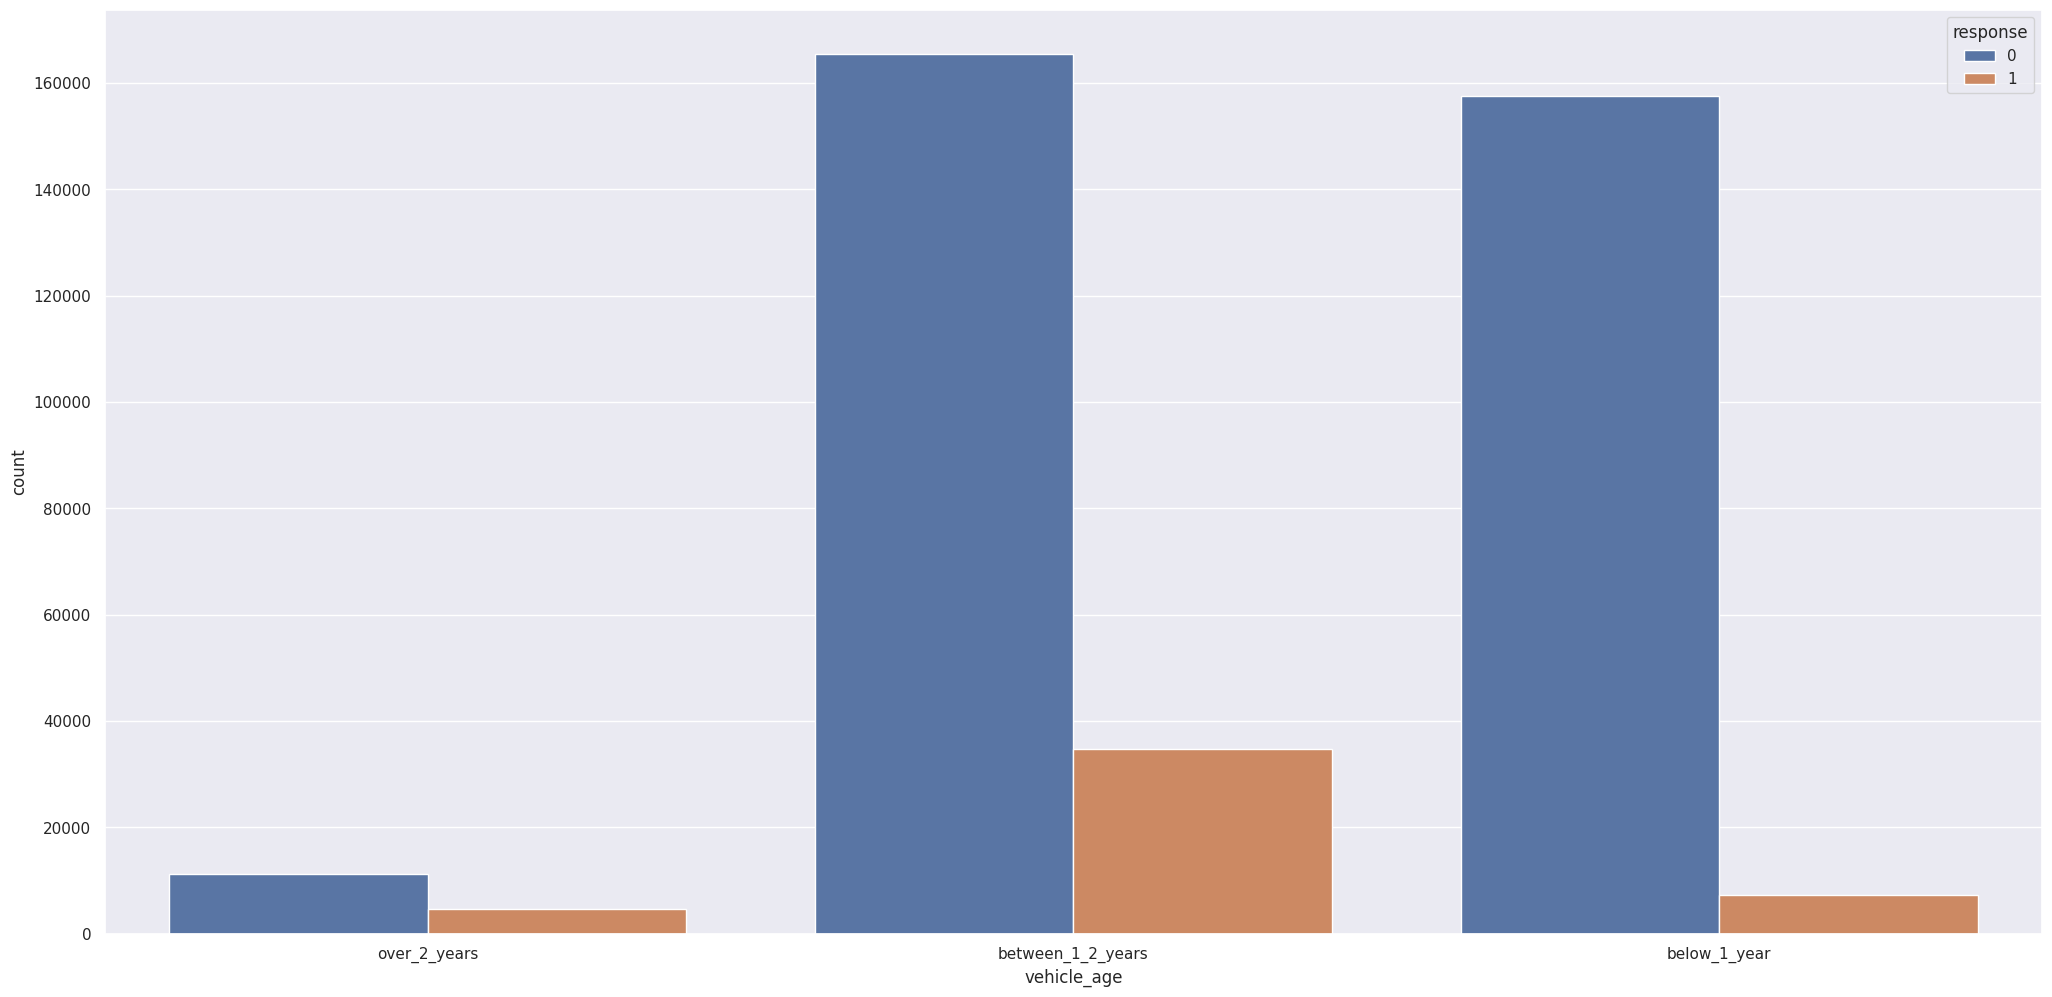

In [24]:
# 'vehicle_age'
sns.countplot(x=df4['vehicle_age'], hue=df4['response'])

df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

### **H6.** Clientes com planos mais caros são mais propensos a contratarem o seguro.
***FALSA.*** Clientes com planos em torno de 30000 (valores intermediários) rúpias são mais propensos a contratarem o seguro.

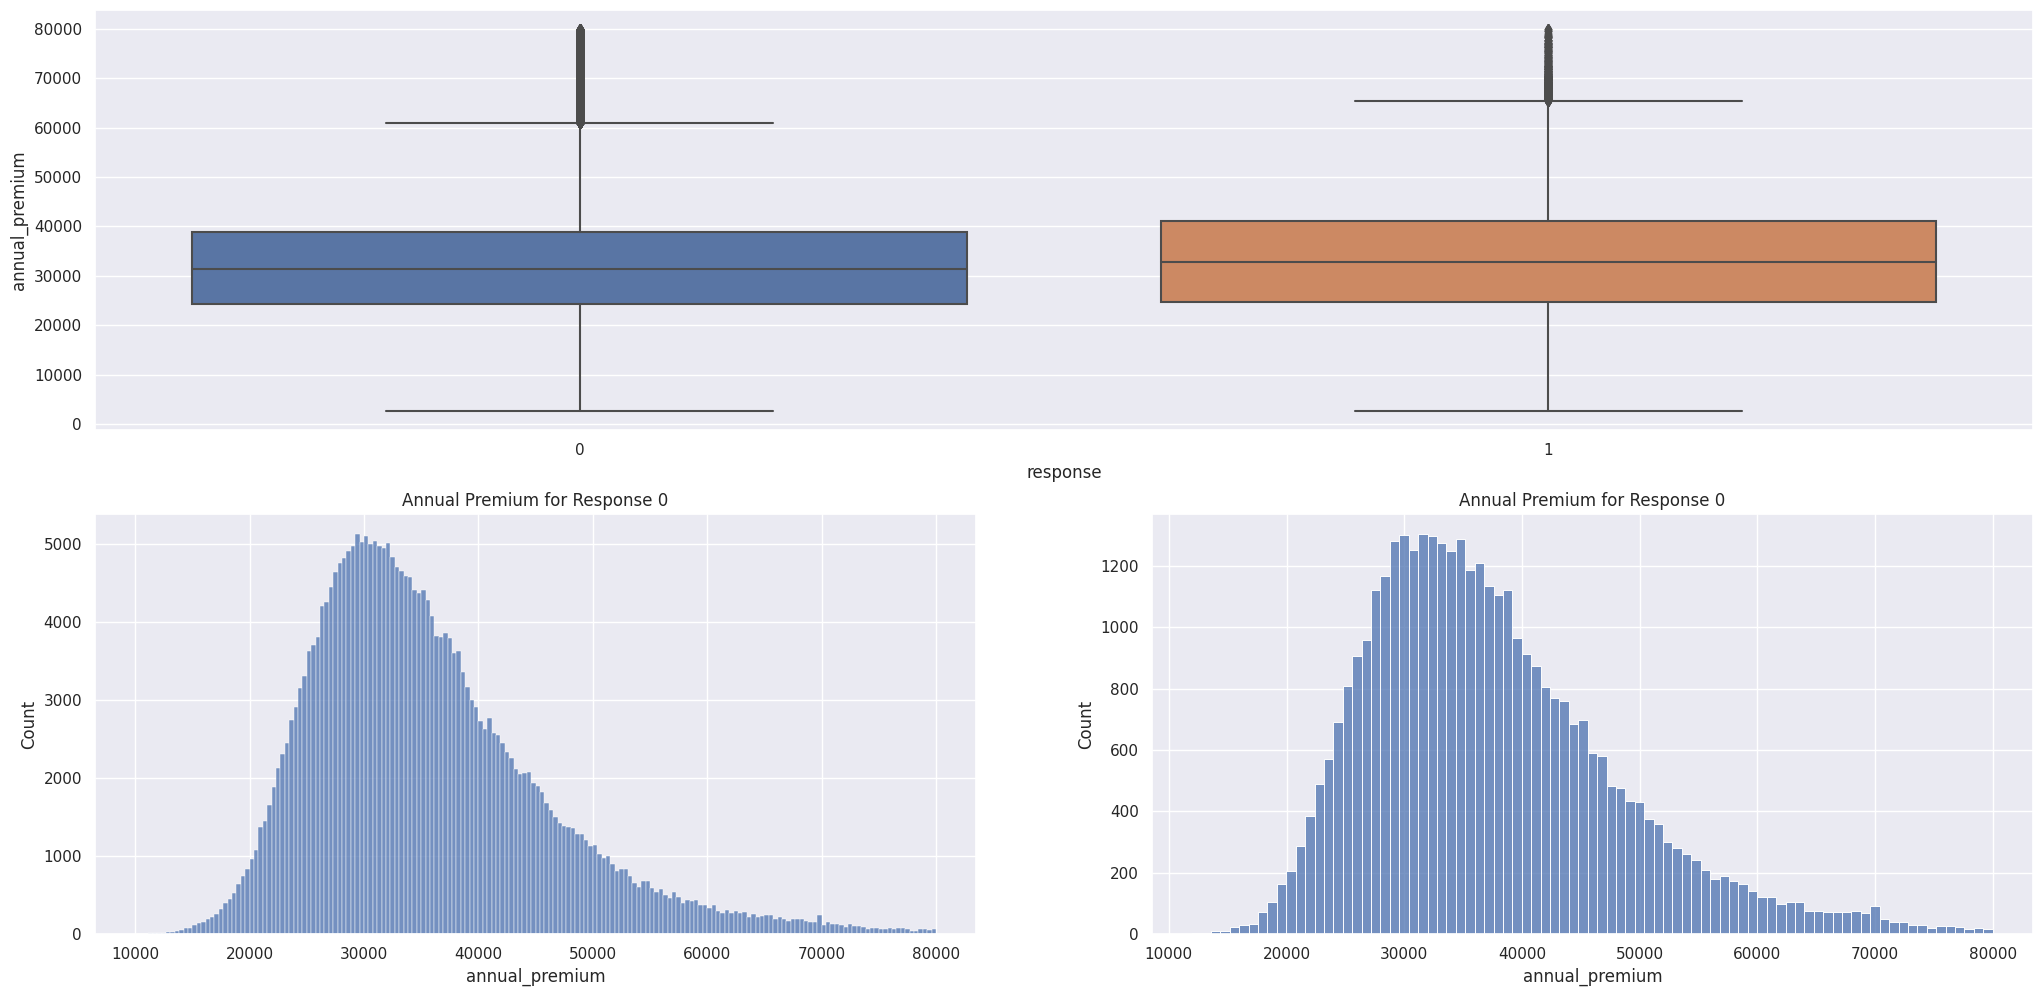

In [22]:
# 'annual_premium'
G = gridspec.GridSpec(2, 2)

aux = df4[df4['annual_premium'] < 80000]
ax1 = plt.subplot(G[0, :])
sns.boxplot(x='response', y='annual_premium', data=aux, ax=ax1)

# Removing outliers for better visualization
aux2 = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]

ax2 = plt.subplot(G[1, 0])
sns.histplot(data=aux2[aux2['response'] == 0], x='annual_premium', ax=ax2)
plt.title('Annual Premium for Response 0')

ax3 = plt.subplot(G[1, 1])
sns.histplot(data=aux2[aux2['response'] == 1], x='annual_premium', ax=ax3)
plt.title('Annual Premium for Response 1');

### **H7.** Clientes mais antigos são mais propensos a contratarem o seguro.
***FALSA.*** Clientes mais antigos não apresentam maior propensão que clientes novos.

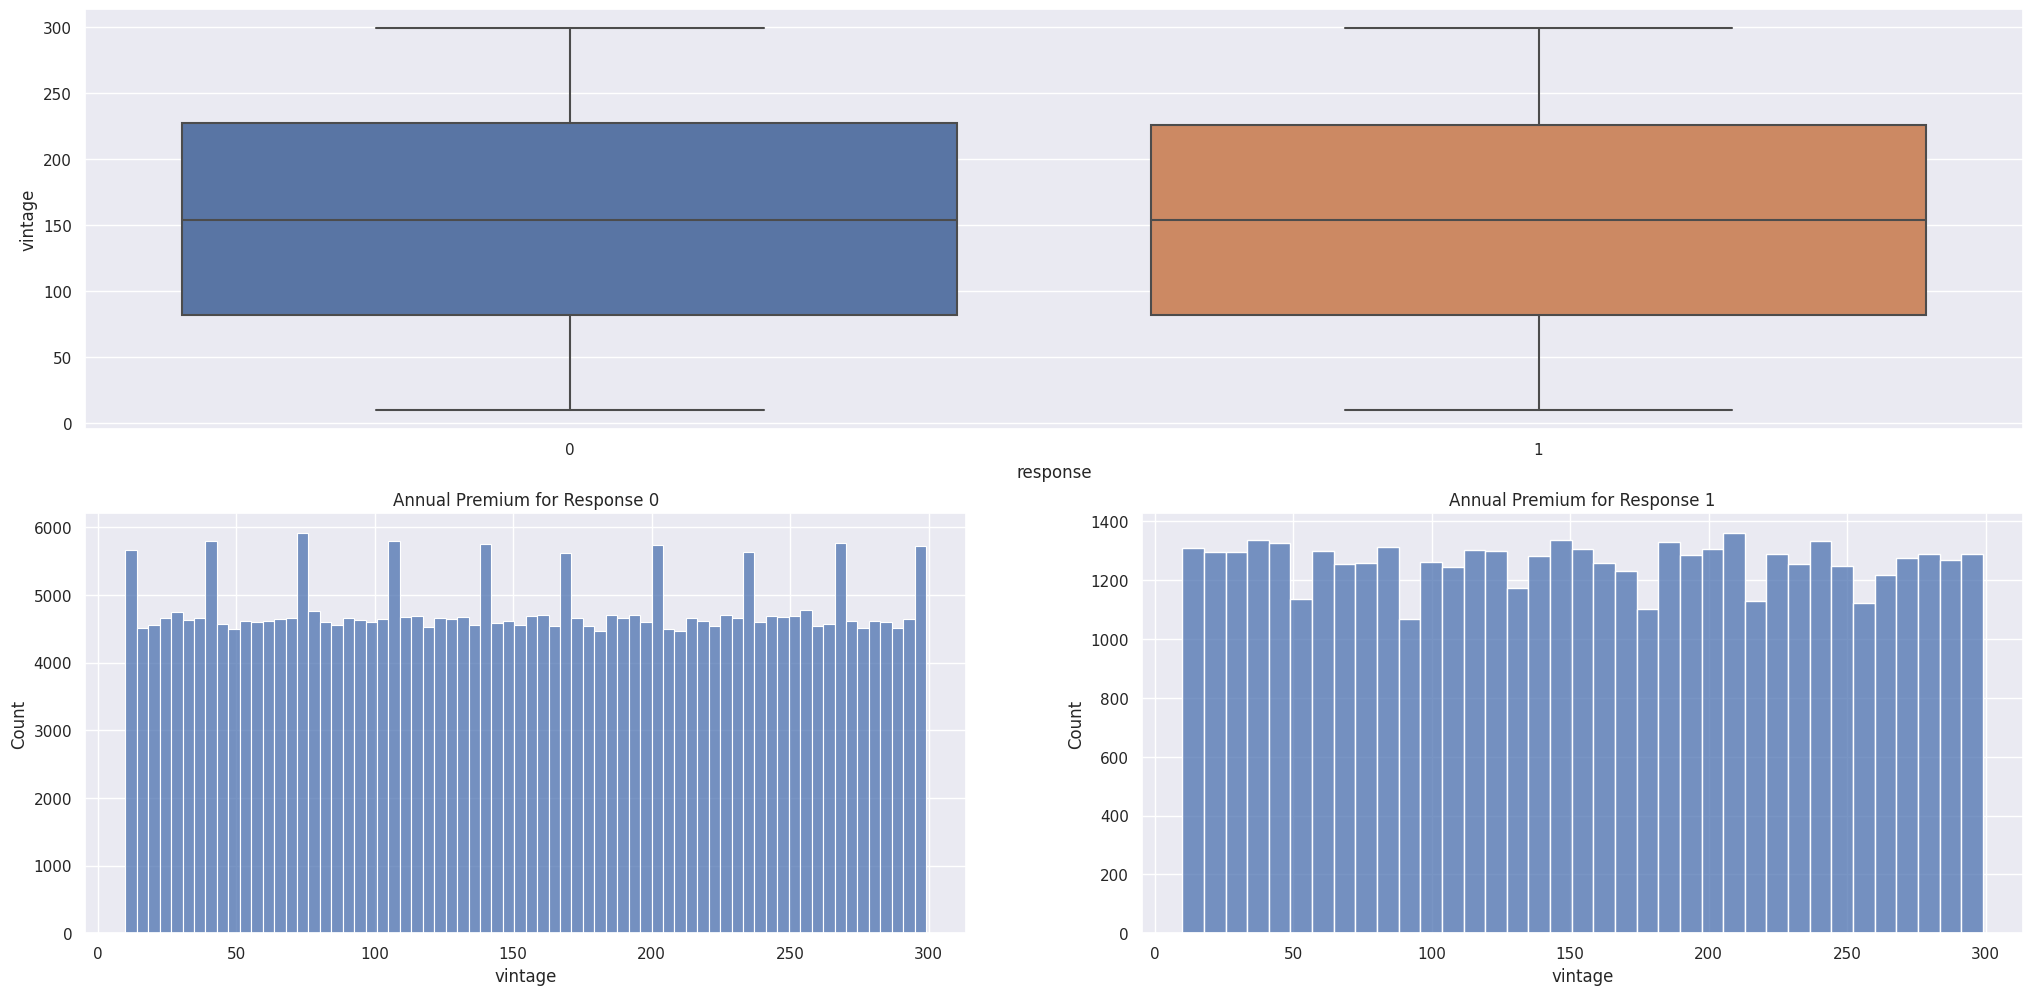

In [24]:
# 'vintage'
G = gridspec.GridSpec(2, 2)

ax1 = plt.subplot(G[0, :])
sns.boxplot(x=df4['response'], y=df4['vintage'])

ax2 = plt.subplot(G[1, 0])
sns.histplot(data=df4[df4['response'] == 0], x='vintage', ax=ax2)
plt.title('Annual Premium for Response 0')

ax3 = plt.subplot(G[1, 1])
sns.histplot(data=df4[df4['response'] == 1], x='vintage', ax=ax3)
plt.title('Annual Premium for Response 1');

### **H8.** Clientes contatados por um determinado meio de comunicação são mais propensos a contratarem o seguro.
***VERDADEIRA.*** Clientes contatados por determinados meios de comunicação sao mais propensos a contratarem o seguro.

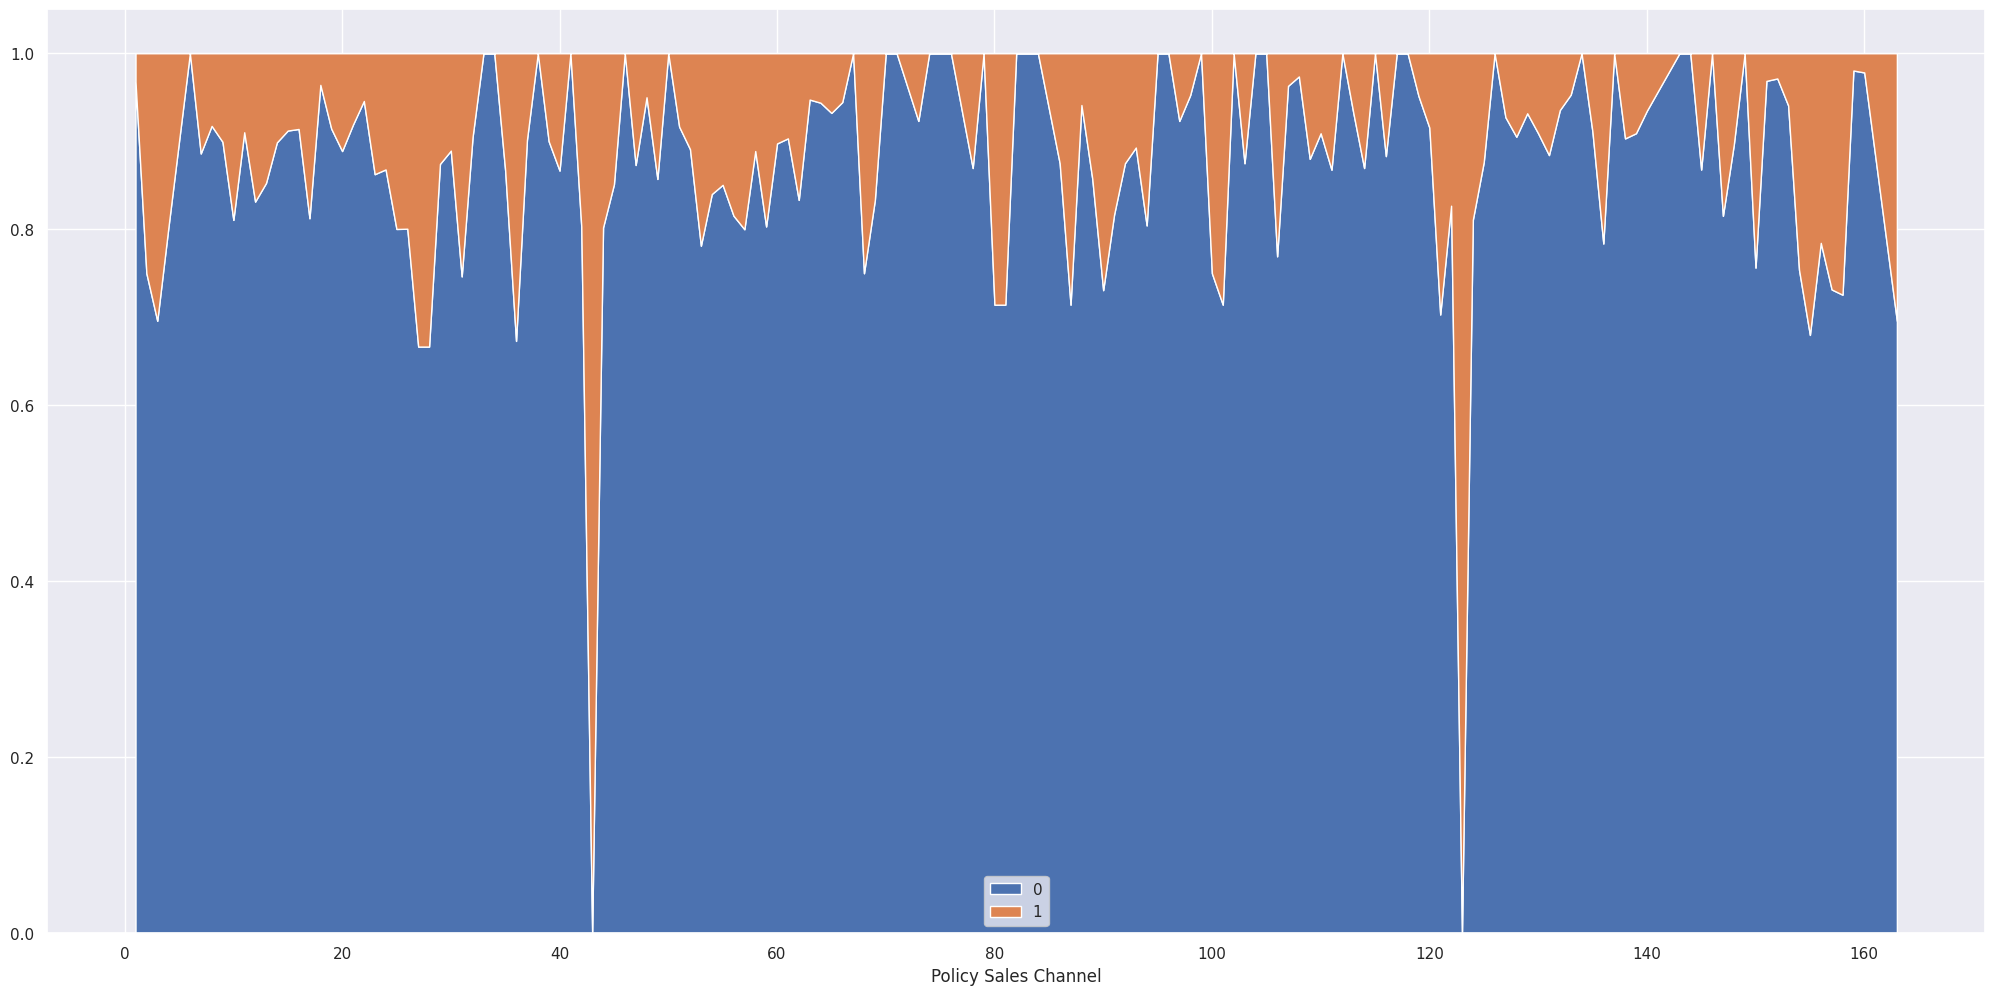

In [23]:
# 'policy_sales_channel'
aux1 = pd.crosstab(df4['policy_sales_channel'], df4['response']).apply(lambda x: x/x.sum(), axis=1).reset_index()

x = aux1['policy_sales_channel']
y1=aux1[0]
y2=aux1[1]

plt.stackplot(x, y1, y2, labels=['0', '1'])
plt.xlabel('Policy Sales Channel')
plt.legend(loc='lower center');

### **H9.** Clientes que já possuem seguro de veículo são menos propensos a contratarem o seguro.
***VERDADEIRA.*** Clientes que não possuem seguro de veículo são mais propensos a contratarem o seguro.

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


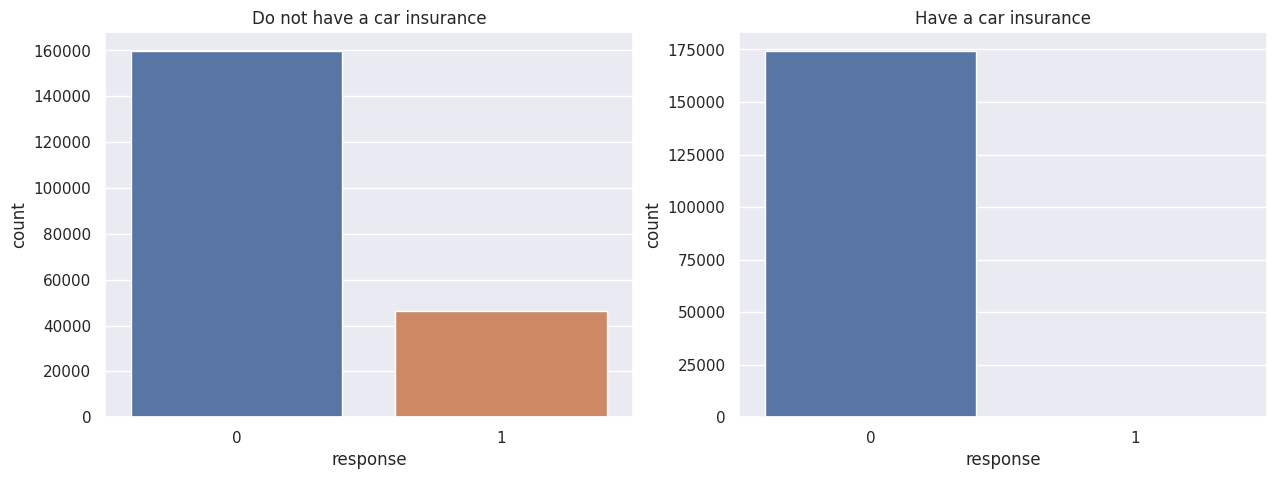

In [19]:
# 'previously_insured'
plt.figure(figsize=(15, 5))
G = gridspec.GridSpec(1, 2)

ax1 = plt.subplot(G[0, 0])
sns.countplot(x='response', data=df4[df4['previously_insured'] == 0], ax=ax1)
plt.title('Do not have a car insurance')

ax2 = plt.subplot(G[0, 1])
sns.countplot(x='response', data=df4[df4['previously_insured'] == 1], ax=ax2)
plt.title('Have a car insurance');

# percentage
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

### **H10.** Clientes que moram em regiões com maior taxa de acidentes são mais propensos a contratarem o seguro.
***INDETERMINADA.*** Uma região apresenta mais clientes propensos, mas é a região com mais clientes no total e não é possível saber a situação socioeconômica da região.

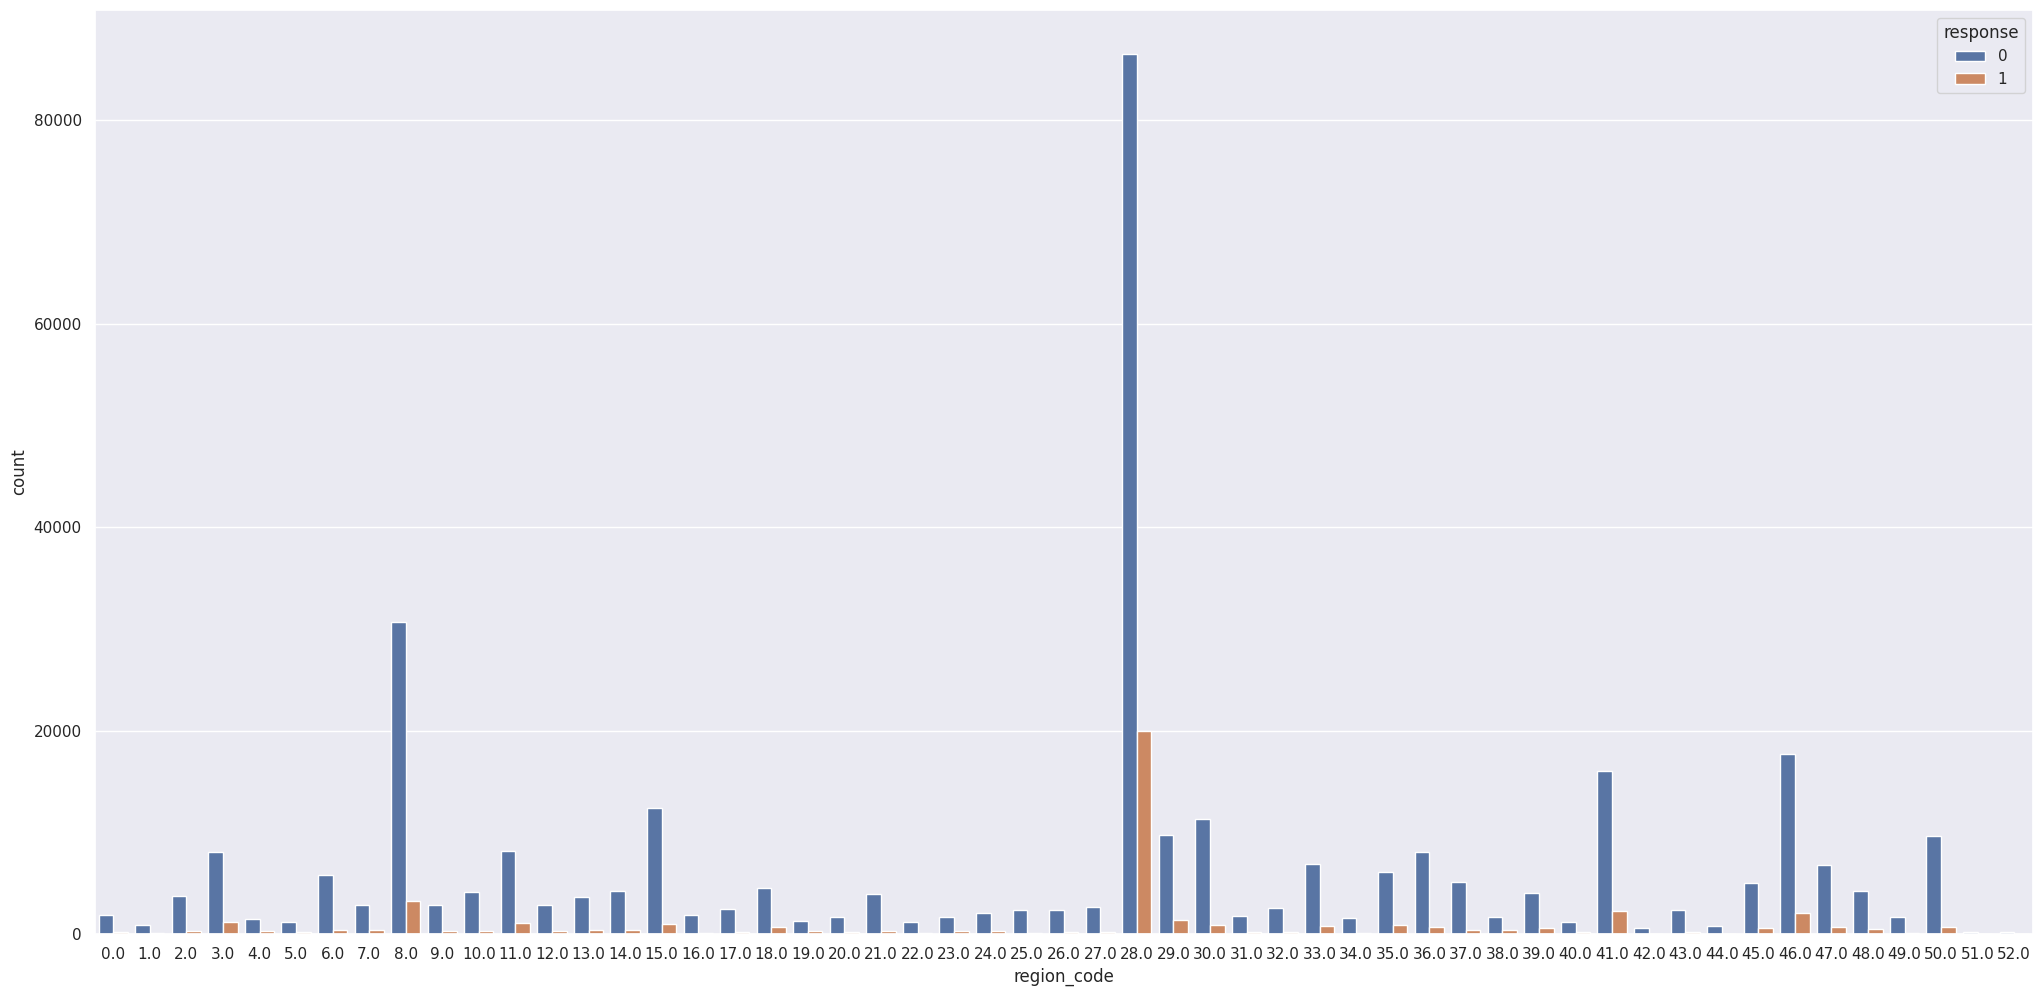

In [18]:
# 'region_code'
sns.countplot(x='region_code', hue='response', data=df4);

## 4.3 Resumo das Hipóteses

| Hipóteses | Conclusão | Relevância |
|-------|-------|-----|
H1| Verdadeira | Média
H2| Falsa | Baixa
H3| Verdadeira | Alta
H4| Verdadeira | Alta
H5| Falsa | Baixa
H6| Falsa | Baixa
H7| Falsa | Baixa
H8| Verdadeira | Alta
H9| Verdadeira | Alta
H10| Indeterminada | Alta


## 4.4 Análise Multivariada

### Atributos Numéricos

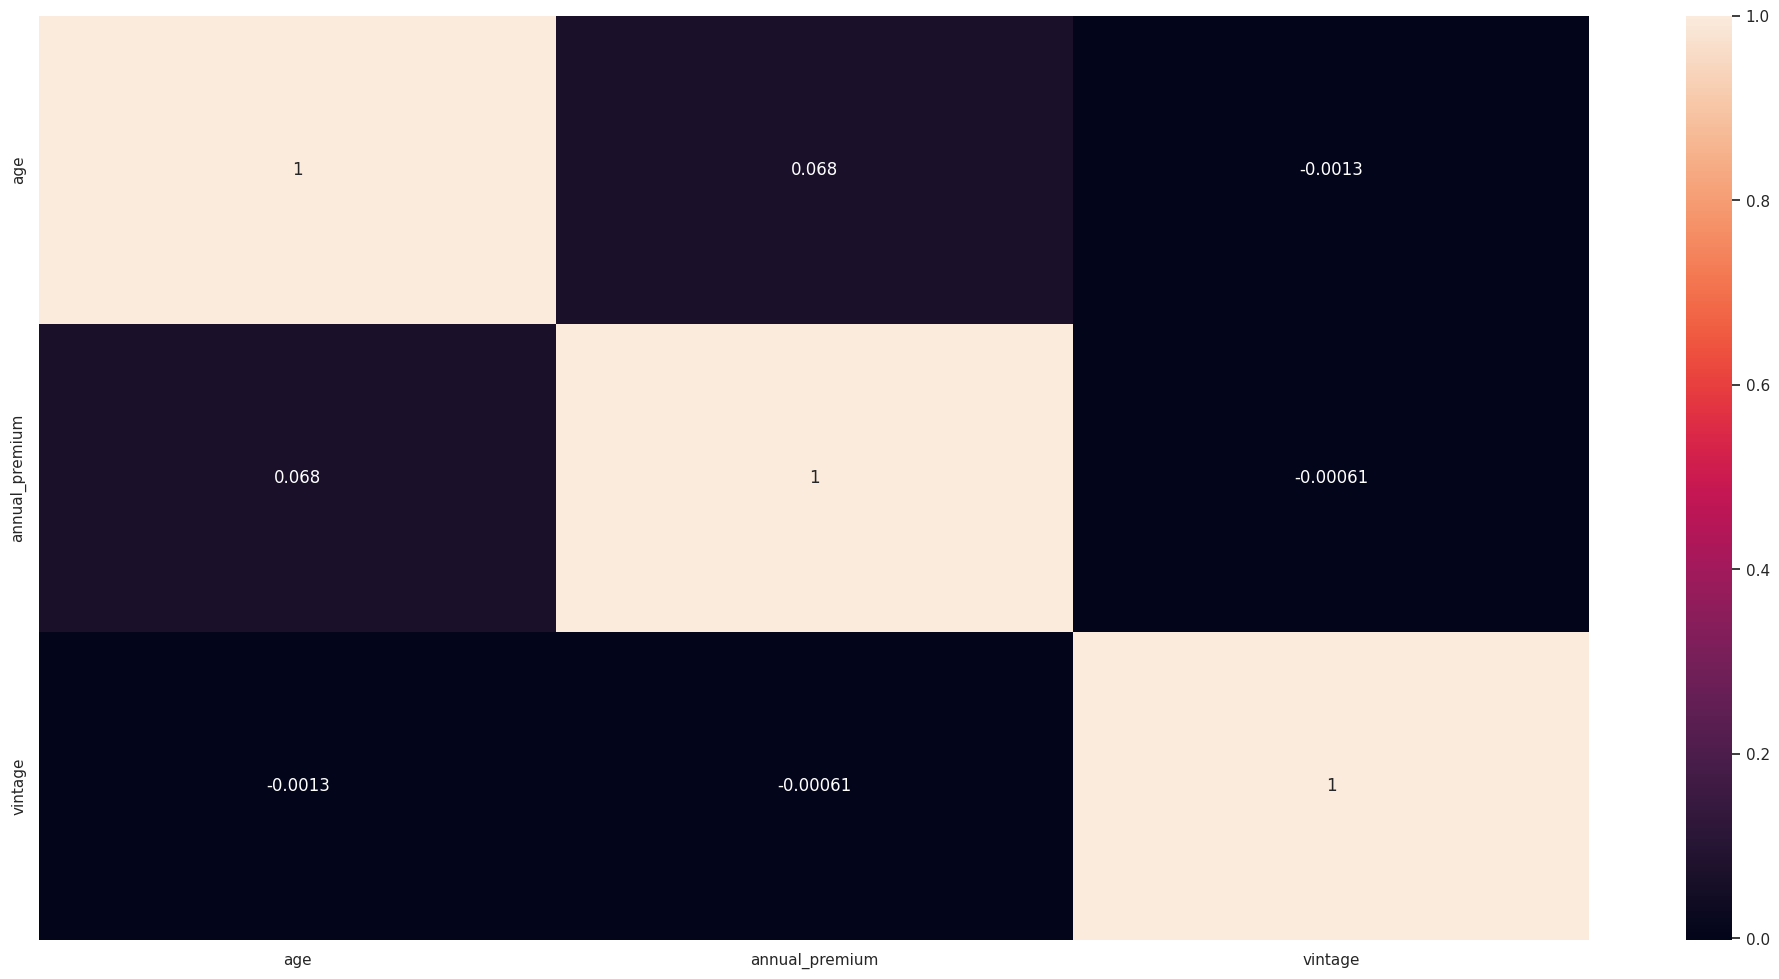

In [55]:
correlation = df4[['age', 'annual_premium', 'vintage']].corr(method='pearson')
sns.heatmap(correlation, annot=True);

In [26]:
df4.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


### Atributos Categóricos

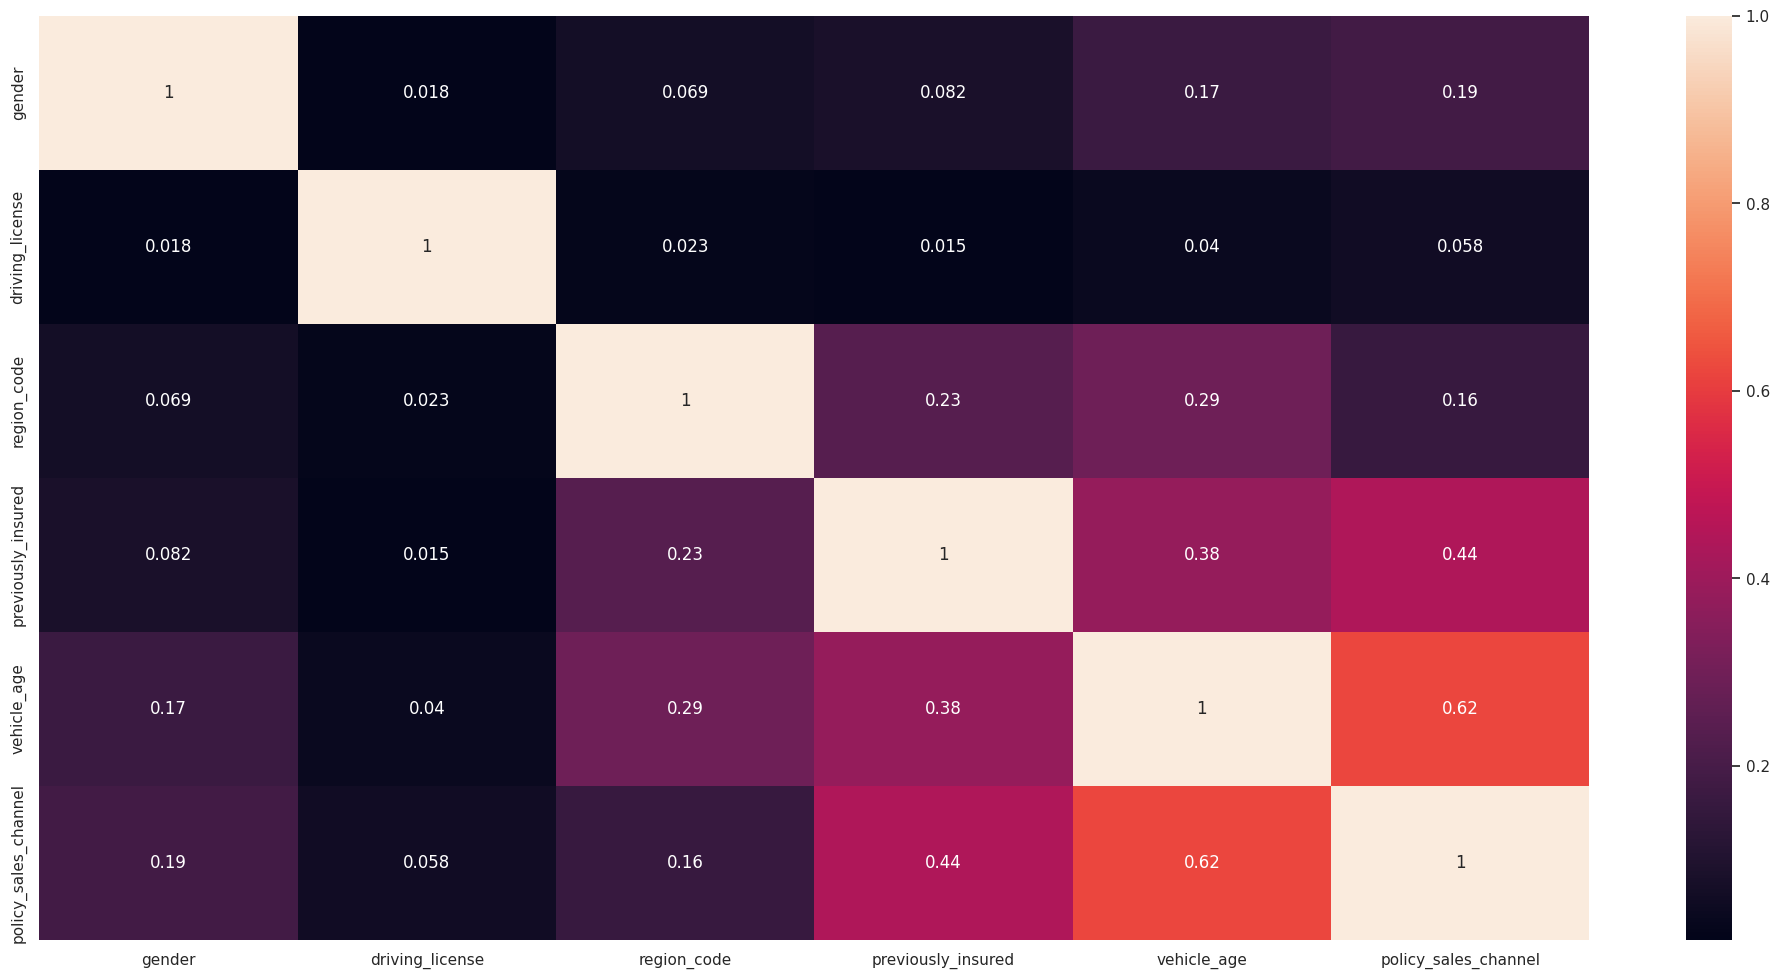

In [51]:
aux = df4[['gender', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 'policy_sales_channel']]

aux2 = pd.DataFrame()

for col1 in aux.columns:
    cramer_list = []
    for col2 in aux.columns:
        cramer_list.append(cramer_v(aux[col1], aux[col2]))
    aux2[col1] = cramer_list

aux2 = aux2.set_index(aux2.columns)
sns.heatmap(aux2, annot=True);

# 5.0 DATA PREPARATION

## 5.1 Data Split 

In [16]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, stratify=y, random_state=26)

# Cross validation
X_train_cv = X_train.copy()
y_train_cv = y_train.copy()

## Standardization

In [17]:
ss = StandardScaler()

# annual_premium
X_train['annual_premium'] = ss.fit_transform(X_train[['annual_premium']].values)

## Rescaling

In [18]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()

# age (since its distribution is not a normal one)
X_train['age'] = mms_age.fit_transform(X_train[['age']].values)

# vintage
X_train['vintage'] = mms_vintage.fit_transform(X_train[['vintage']].values)

## Encoder

In [19]:
# gender
le = LabelEncoder()
X_train['gender'] = le.fit_transform(X_train['gender'])


# region_code - Target Enconder
te = TargetEncoder()
X_train['region_code'] = X_train['region_code'].astype(str)
X_train['region_code'] = te.fit_transform(X_train['region_code'], y_train)


# vehicle_age - Ordinal Encoding
vehicle_age_dict = {'below_1_year': 1, 'between_1_2_years': 2, 'over_2_years': 3}
X_train['vehicle_age'] = X_train['vehicle_age'].map(vehicle_age_dict)


# policy_sales_channel - Frequency Encoding
X_train['policy_sales_channel'] = X_train['policy_sales_channel'].astype(str)
cfe = CountFrequencyEncoder(encoding_method='frequency', variables=['policy_sales_channel'])
X_train = cfe.fit_transform(X_train)

/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


## Validation Encoding

In [20]:
# annual_premium
X_val['annual_premium'] = ss.transform(X_val[['annual_premium']].values)

# age (since its distribution is not a normal one)
X_val['age'] = mms_age.transform(X_val[['age']].values)

# vintage
X_val['vintage'] = mms_vintage.transform(X_val[['vintage']].values)

# gender
X_val['gender'] = le.transform(X_val['gender'])

# region_code - Target Enconder
X_val['region_code'] = X_val['region_code'].astype(str)
X_val['region_code'] = te.transform(X_val['region_code'])

# vehicle_age - Ordinal Encoding
vehicle_age_dict = {'below_1_year': 1, 'between_1_2_years': 2, 'over_2_years': 3}
X_val['vehicle_age'] = X_val['vehicle_age'].map(vehicle_age_dict)

# policy_sales_channel - Frequency Encoding
X_val['policy_sales_channel'] = X_val['policy_sales_channel'].astype(str)
X_val = cfe.transform(X_val)
X_val = X_val.replace(np.nan, 0)

/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/feature_engine/encoding/base_encoder.py:210: UserWarning: During the encoding, NaN values were introduced in the feature(s) policy_sales_channel.
  warnings.warn(


# 6.0 FEATURE SELECTION

## 6.1 Boruta Selection

In [34]:
# training and test dataset for Boruta
X_train_b = X_train.drop(['id', 'region_code'], axis=1).values
y_train_b = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_b, y_train_b)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration:

In [36]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop(['id', 'region_code'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = np.setdiff1d(X_train_fs.columns, cols_selected_boruta)

In [42]:
print(f'Cols selected:{cols_selected_boruta}')
print(f'Cols not selected: {cols_not_selected_boruta}')

Cols selected:['vehicle_damage']
Cols not selected: ['age' 'annual_premium' 'driving_license' 'gender' 'policy_sales_channel'
 'previously_insured' 'region_code_encoded' 'vehicle_age' 'vintage']


## 6.2 Features Importance

In [45]:
# Model
forest = ExtraTreesClassifier(n_estimators=250, n_jobs=-1)

# data preparation
X_train_n = X_train.drop(['id', 'region_code'], axis=1)
y_train_n = y_train.values

forest.fit(X_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1)

In [46]:
# Print the feature ranking
print('Features ranking:')
df = pd.DataFrame()

for i, j in zip(X_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature':i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

Features ranking:
                feature  importance
0               vintage    0.278095
0        annual_premium    0.246704
0                   age    0.157871
0   region_code_encoded    0.105943
0        vehicle_damage    0.071834
0  policy_sales_channel    0.060828
0    previously_insured    0.056785
0           vehicle_age    0.016155
0                gender    0.005294
0       driving_license    0.000489


In [21]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage',
                 'policy_sales_channel', 'previously_insured']

# 7.0 MACHINE LEARNING

In [22]:
x_train = X_train[cols_selected]
x_val = X_val[cols_selected]

In [23]:
df7 = X_val.copy()
df7['response'] = y_val.copy()

## 7.1 Models

### K-Nearest Neighbors

In [24]:
# Model
knn_model = KNeighborsClassifier(n_neighbors=10)

# model training
knn_model.fit(x_train, y_train)

# model prediction - GENERALIZATION
yhat_knn = knn_model.predict_proba(x_val)

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

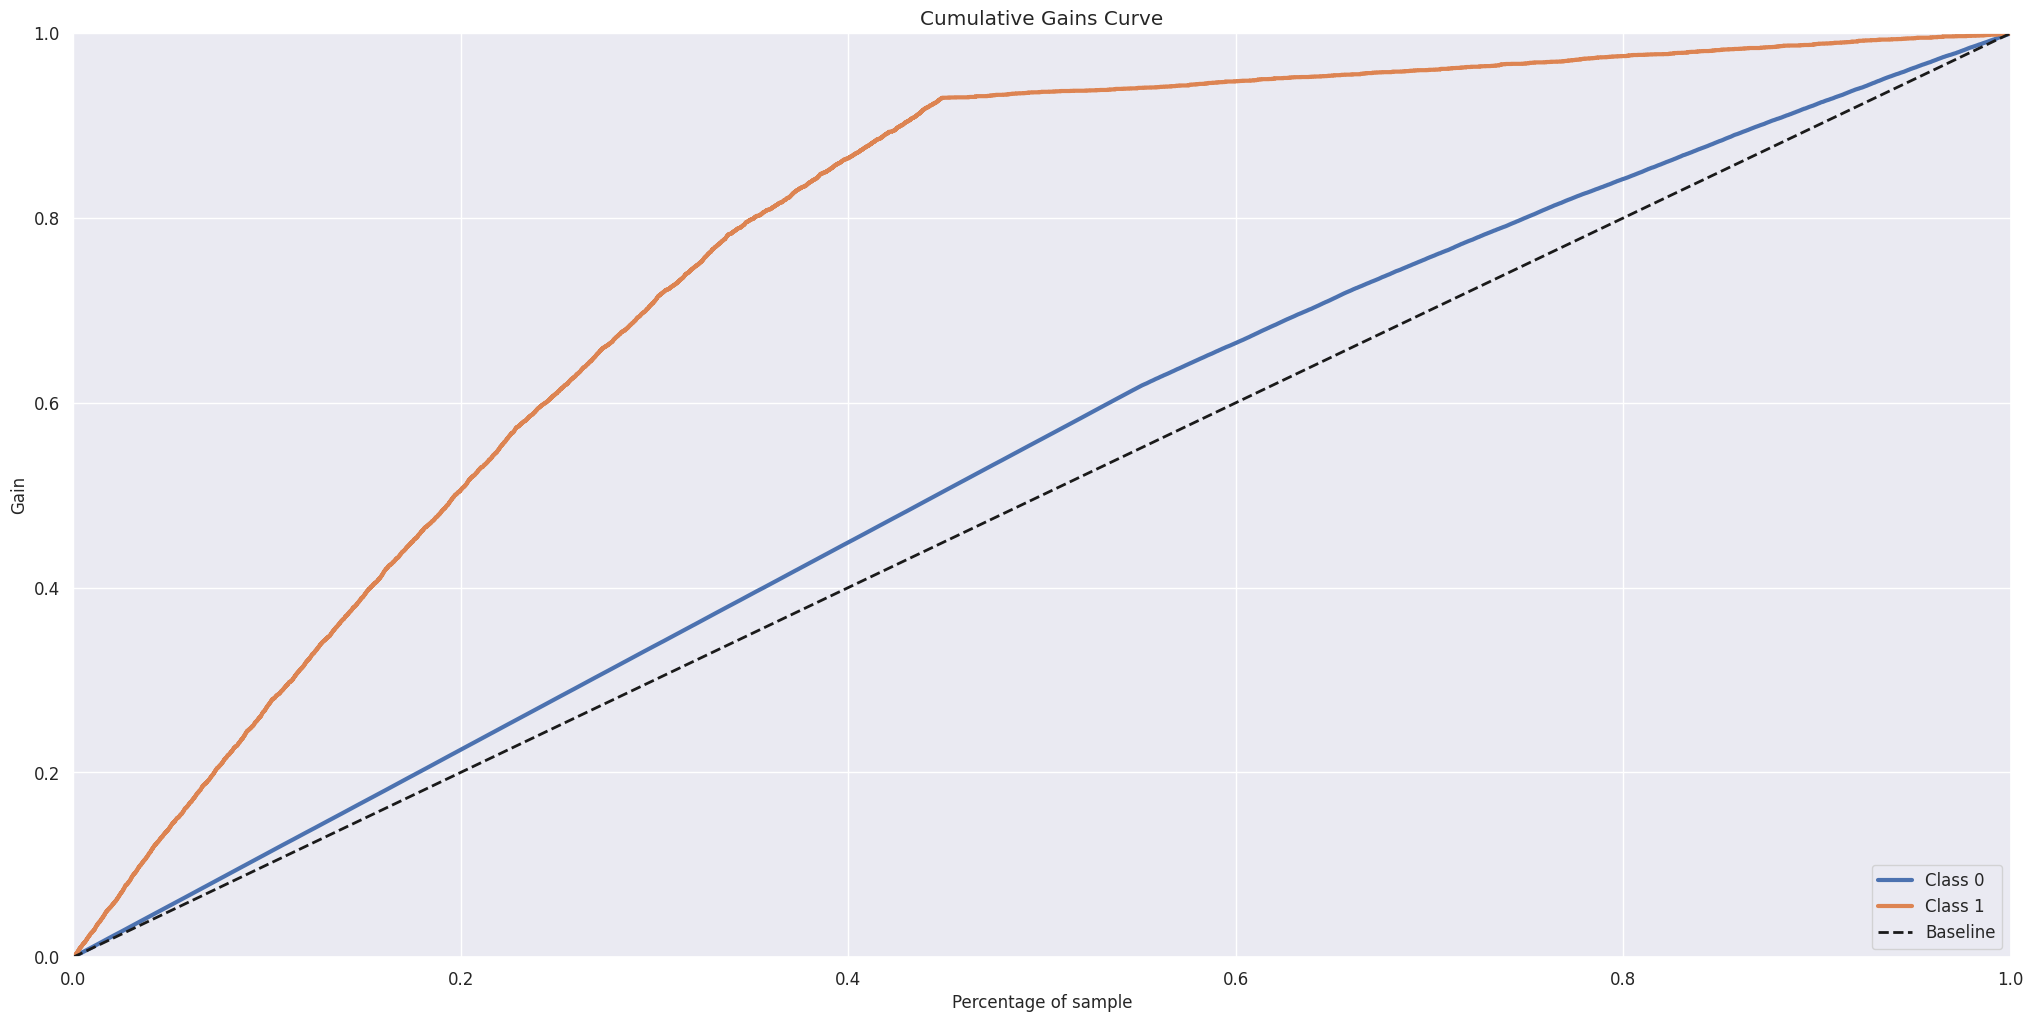

In [25]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn)

In [26]:
print(f'Precision at k: {precision_at_k(df7, yhat_knn)}')
print(f'Recall at k: {recall_at_k(df7, yhat_knn)}')

Precision at k: 0.27993600319984
Recall at k: 0.7990580847723705


#### Cross Validation

In [27]:
cv_knn = cross_validation(knn_model, 5, X_train_cv, y_train_cv)

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

### Logistic Regression

In [28]:
# Model
lr_model = LogisticRegression()

# model training
lr_model.fit(x_train, y_train)

# model prediction - GENERALIZATION
yhat_lr = lr_model.predict_proba(x_val)

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

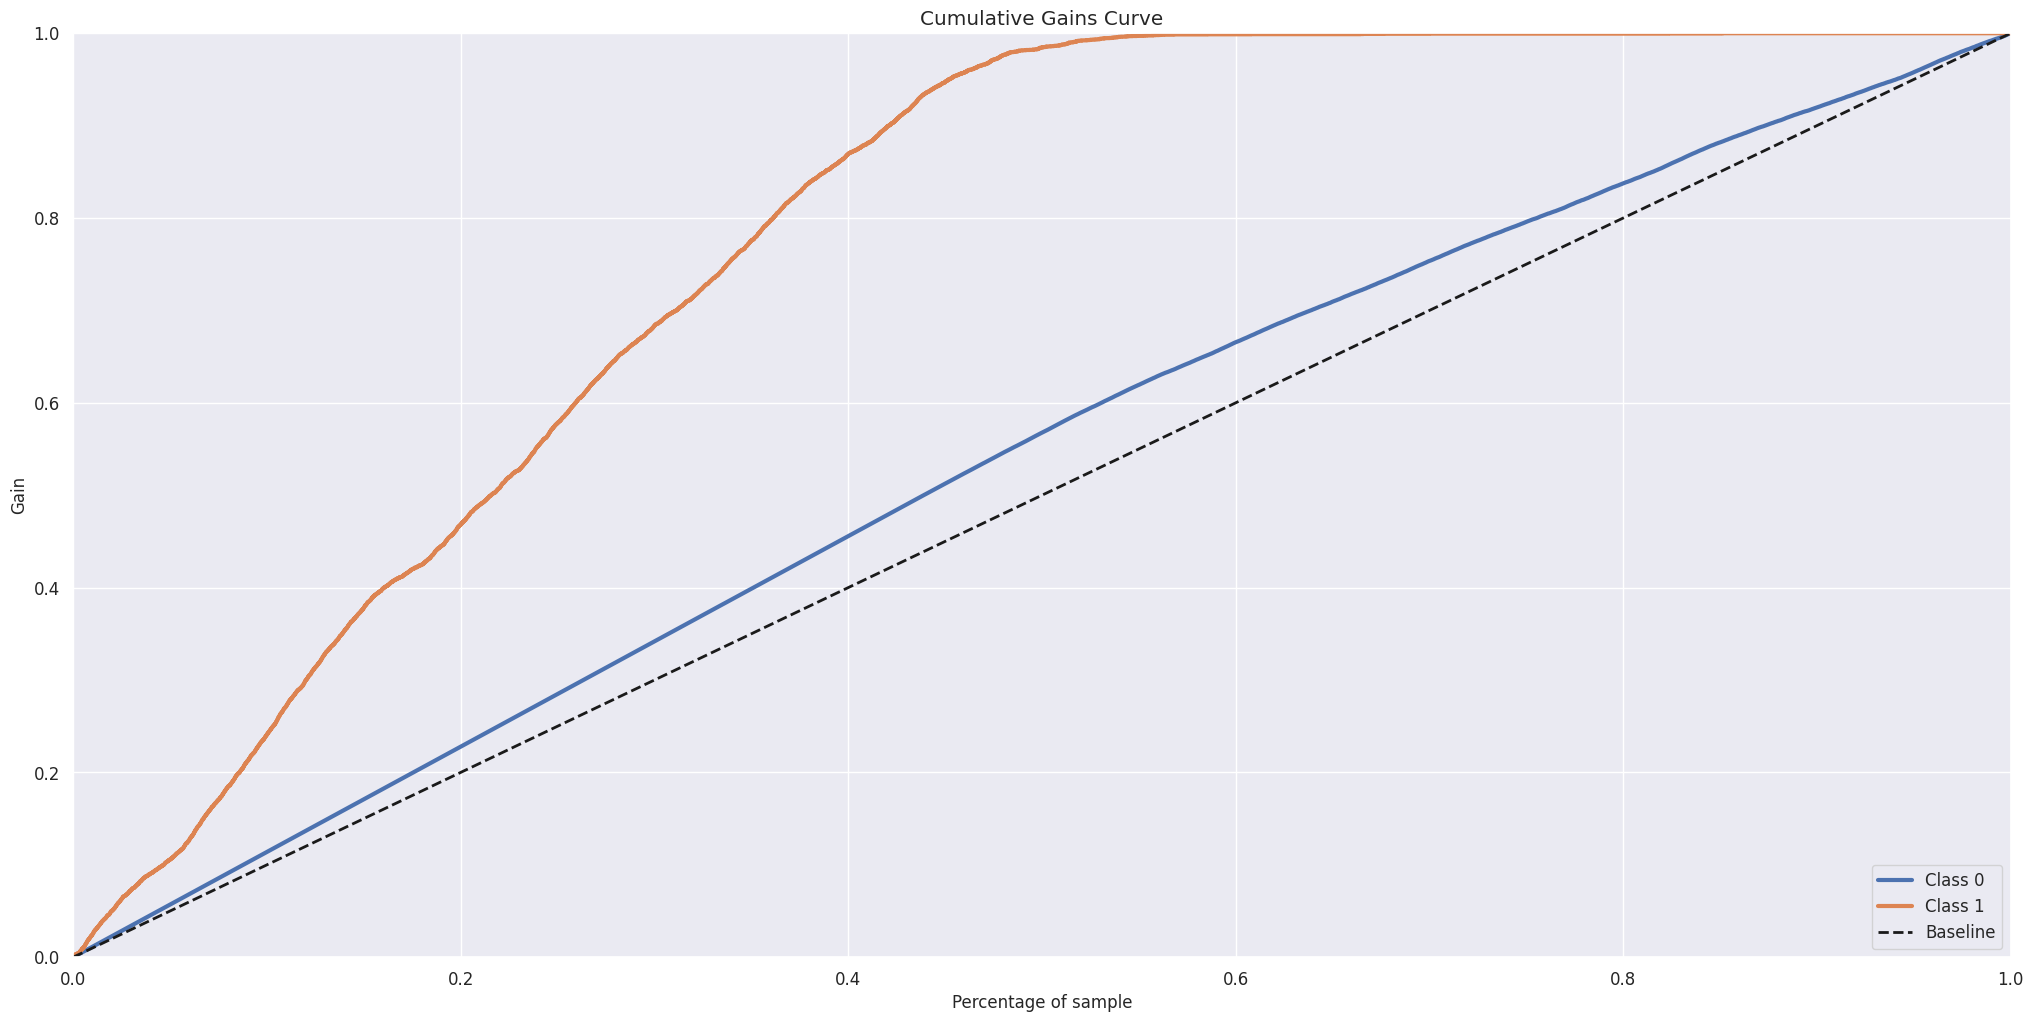

In [29]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr)

In [30]:
print(f'Precision at k: {precision_at_k(df7, yhat_lr)}')
print(f'Recall at k: {recall_at_k(df7, yhat_lr)}')

Precision at k: 0.27158642067896605
Recall at k: 0.7752247752247752


#### Cross Validation

In [31]:
cv_lr = cross_validation(lr_model, 5, X_train_cv, y_train_cv)
cv_lr

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

,Model,Precision at k,Recall at k
0,LogisticRegression,0.2798+/-0.0018,0.7048+/-0.0046


### Random Forest

In [32]:
# Model
rf_model = RandomForestClassifier(n_jobs=-1)

# model training
rf_model.fit(x_train, y_train)

# model prediction - GENERALIZATION
yhat_rf = lr_model.predict_proba(x_val)

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

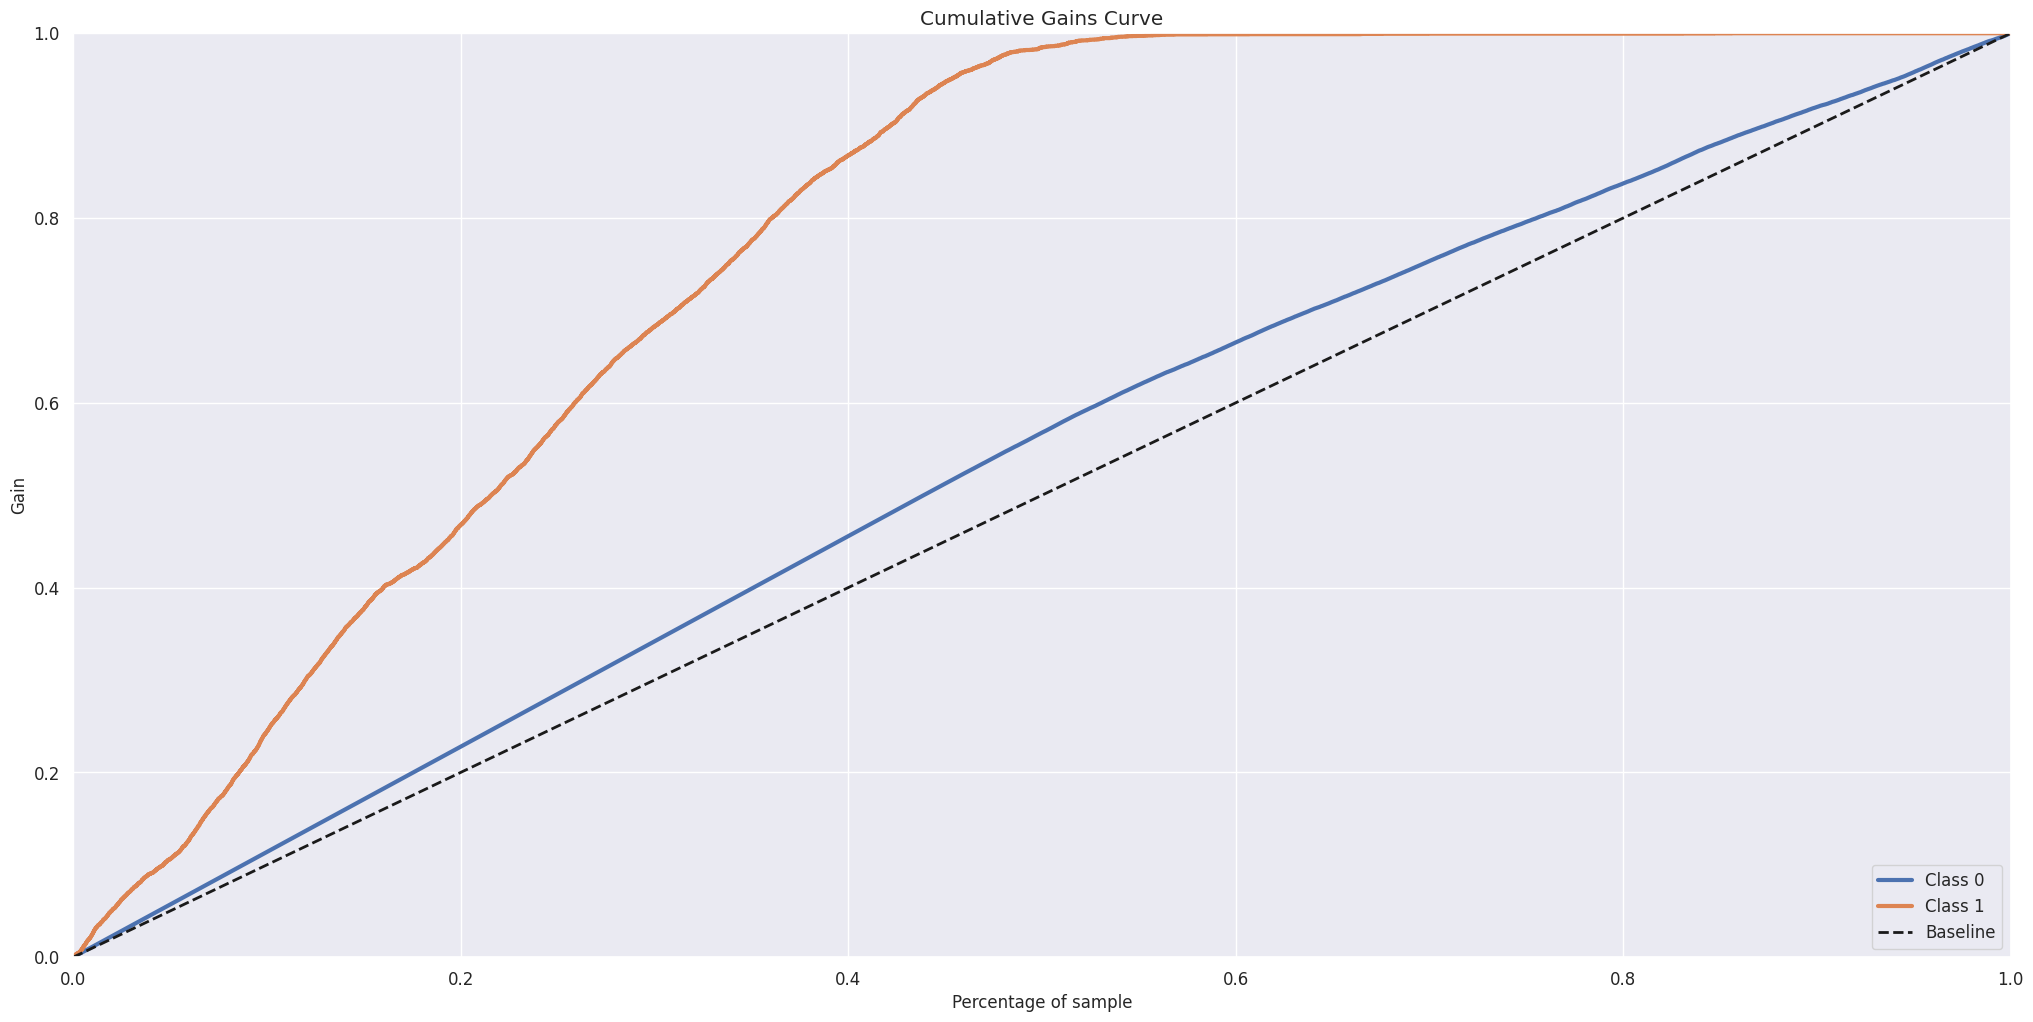

In [33]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf)

In [34]:
print(f'Precision at k: {precision_at_k(df7, yhat_rf)}')
print(f'Recall at k: {recall_at_k(df7, yhat_rf)}')

Precision at k: 0.27148642567871606
Recall at k: 0.7749393463679178


#### Cross Validation

In [35]:
cv_rf = cross_validation(rf_model, 5, X_train_cv, y_train_cv)
cv_rf

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

,Model,Precision at k,Recall at k
0,RandomForestClassifier,0.2965+/-0.0006,0.7469+/-0.0016


### XGBoost

In [36]:
# Model
xgb_model = XGBClassifier(max_delta_step=1, n_jobs=-1)

# model training
xgb_model.fit(x_train, y_train)

# model prediction
yhat_xgb = xgb_model.predict_proba(x_val)

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

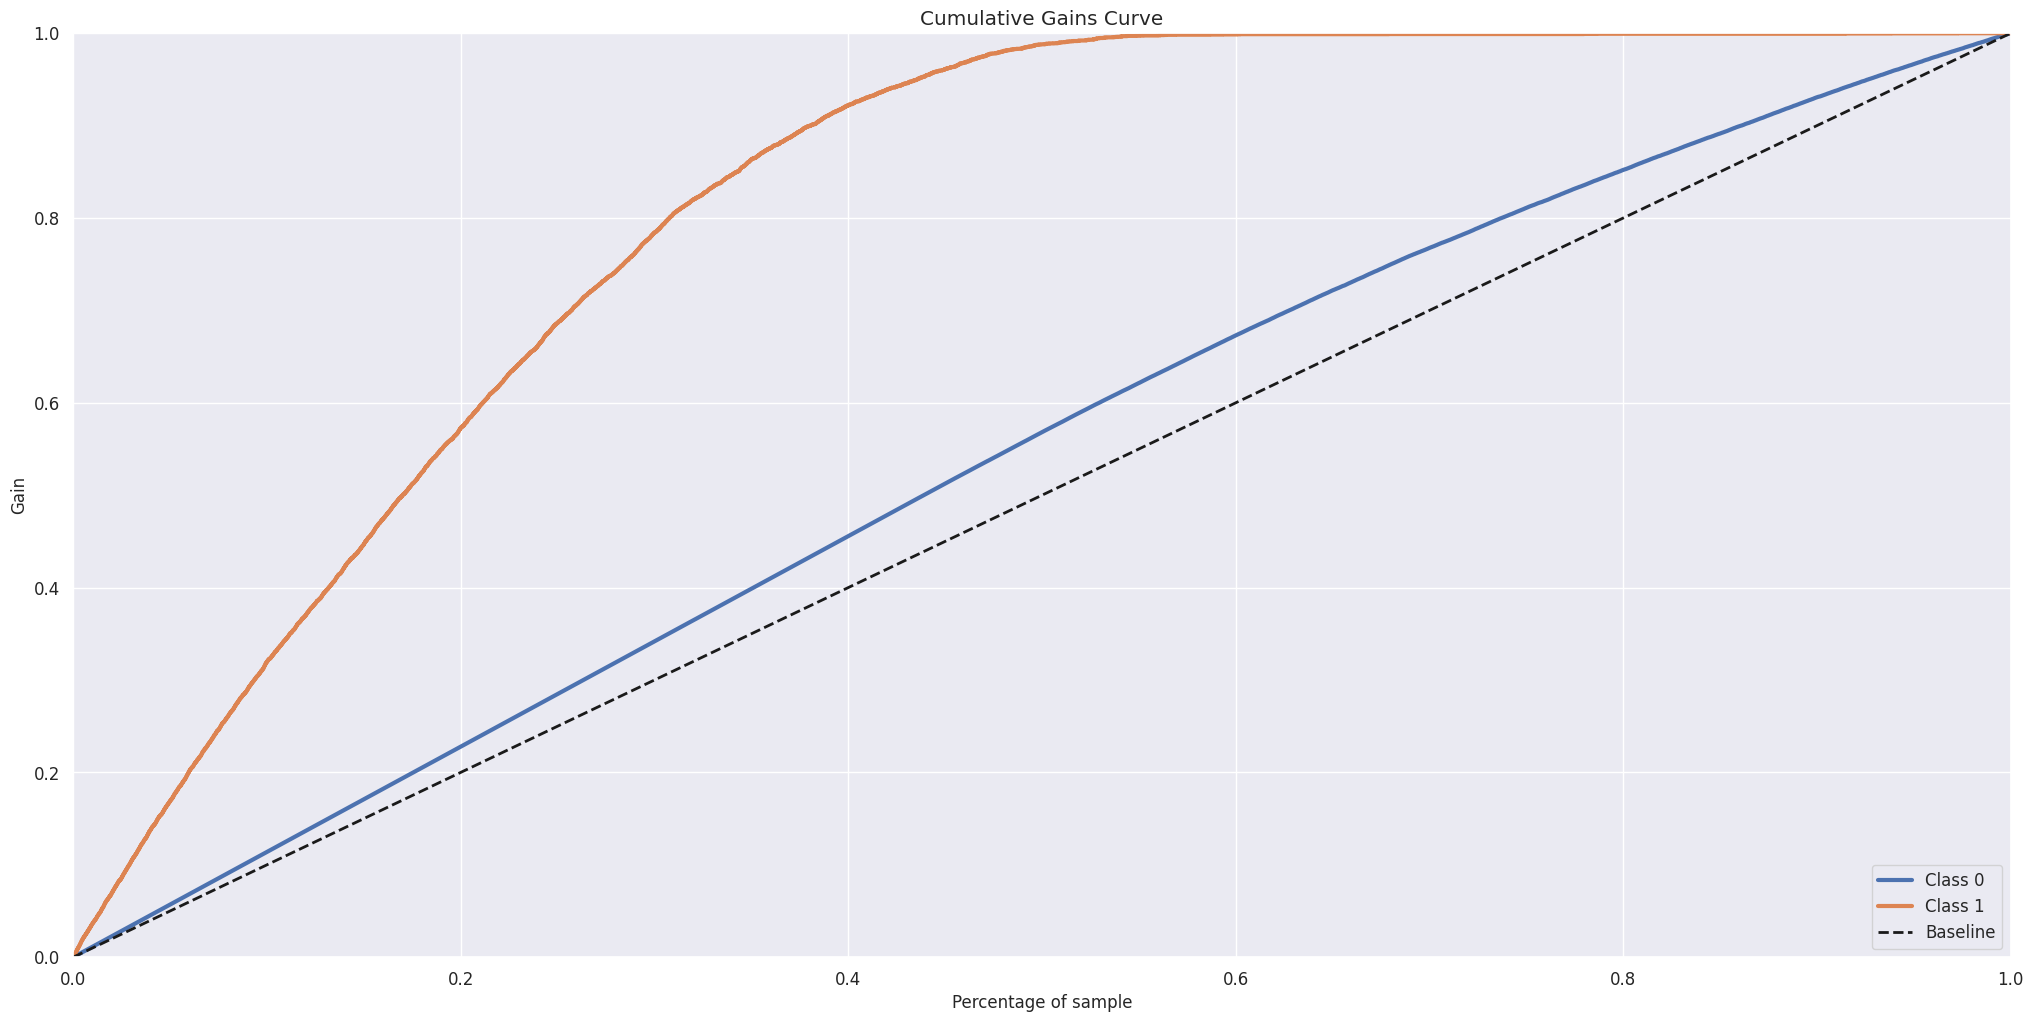

In [37]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb)

In [38]:
print(f'Precision at k: {precision_at_k(df7, yhat_xgb)}')
print(f'Recall at k: {recall_at_k(df7, yhat_xgb)}')

Precision at k: 0.3023848807559622
Recall at k: 0.8631368631368631


#### Cross Validation

In [39]:
cv_xgb = cross_validation(xgb_model, 5, X_train_cv, y_train_cv)

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['policy_sales_channel'] = X_train_fold['policy_sales_channel'].astype(str)
/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

/tmp/ipykernel_24990/4150216634.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['policy_sales_channel'] = X_test_fold['policy_sales_channel'].astype(str)
/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/feature_engine/encoding/base_encoder.py:210: UserWarning: During the encoding, NaN values were introduced in the feature(s) policy_sales_channel.
  warnings.warn(
/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['an

### LightGBM

In [40]:
# Model
lgbm_model = LGBMClassifier()

# model training
lgbm_model.fit(x_train, y_train)

# model prediction
yhat_lgbm = lgbm_model.predict_proba(x_val)

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

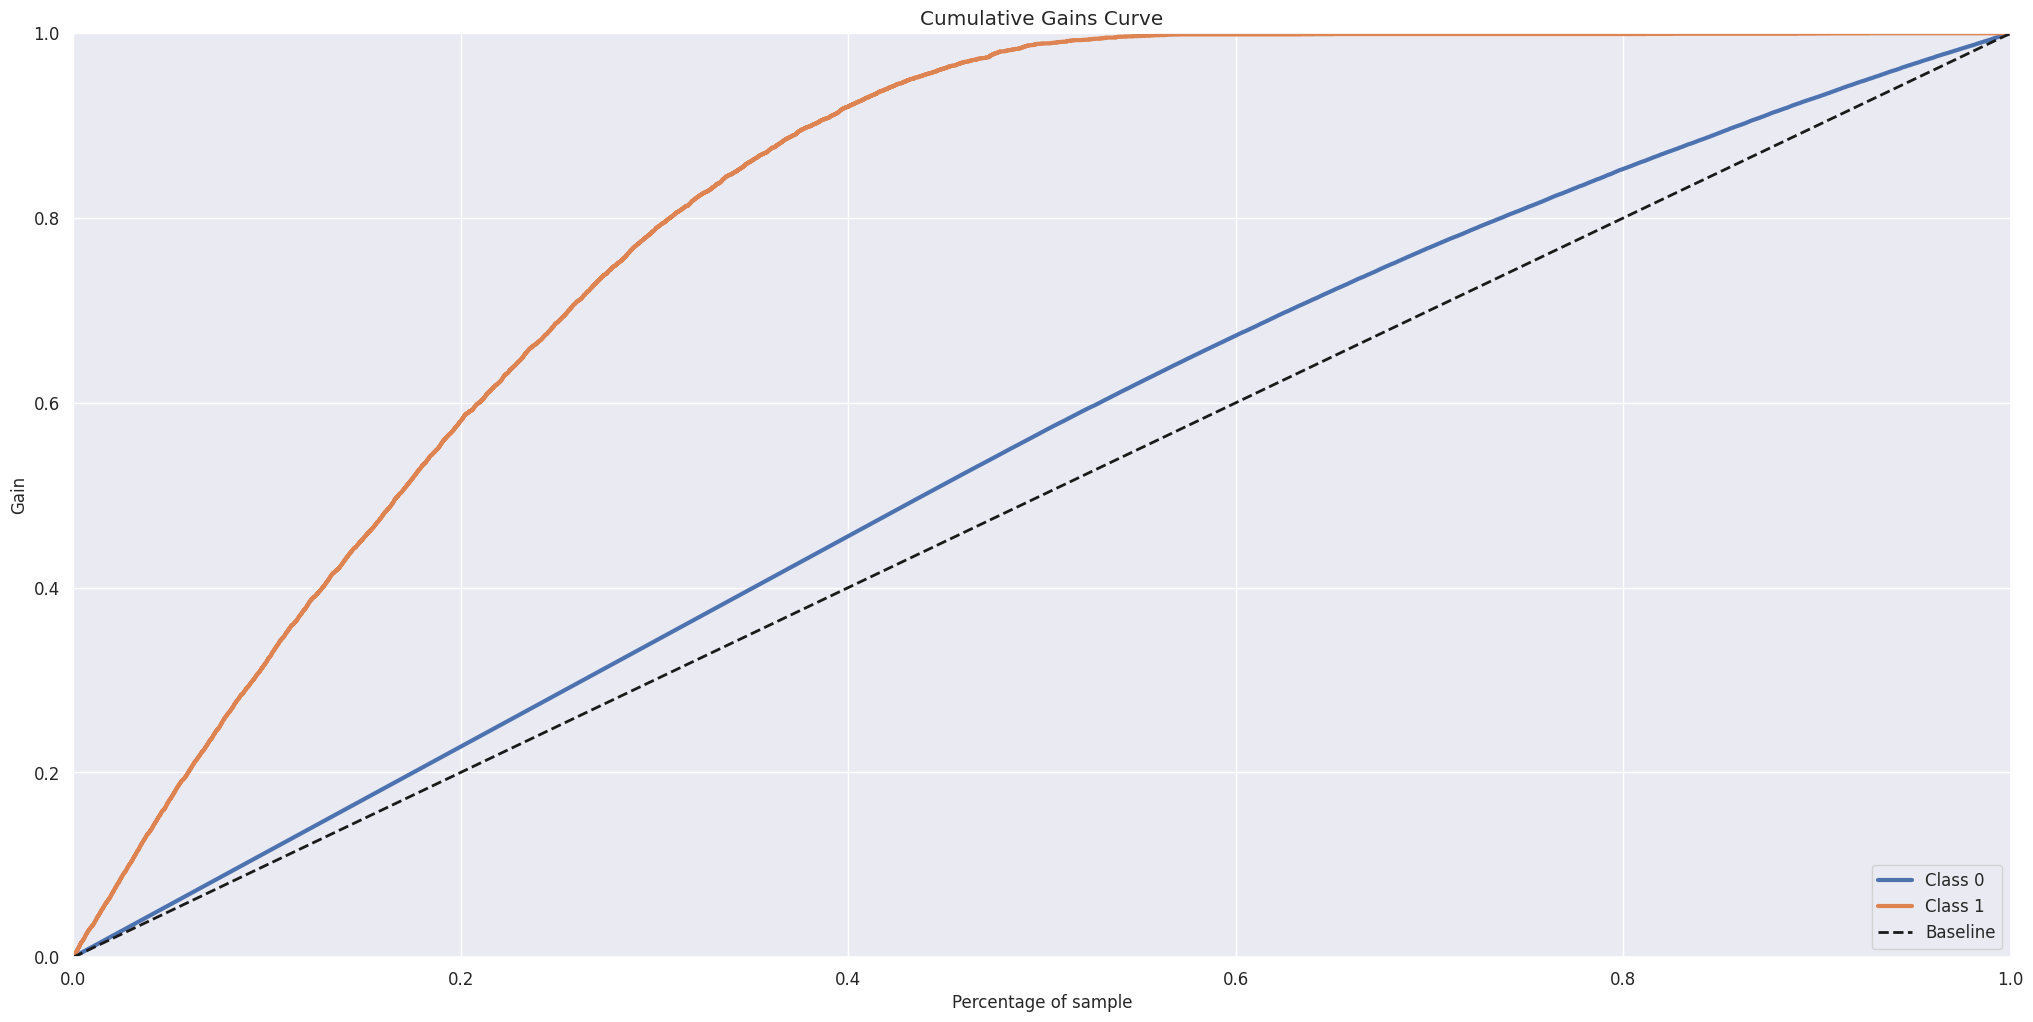

In [41]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lgbm)

In [42]:
print(f'Precision at k: {precision_at_k(df7, yhat_lgbm)}')
print(f'Recall at k: {recall_at_k(df7, yhat_lgbm)}')

Precision at k: 0.30183490825458725
Recall at k: 0.8615670044241472


#### Cross Validation

In [43]:
cv_lgbm = cross_validation(lgbm_model, 5, X_train_cv, y_train_cv)

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['policy_sales_channel'] = X_train_fold['policy_sales_channel'].astype(str)
/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

### CatBoost

In [44]:
# Model
cat_model = CatBoostClassifier()

# model training
cat_model.fit(x_train, y_train)

# model prediction
yhat_cat = cat_model.predict_proba(x_val)

Learning rate set to 0.121592
0:	learn: 0.5015111	total: 117ms	remaining: 1m 56s
1:	learn: 0.4013781	total: 194ms	remaining: 1m 36s
2:	learn: 0.3497762	total: 266ms	remaining: 1m 28s
3:	learn: 0.3219962	total: 331ms	remaining: 1m 22s
4:	learn: 0.3065660	total: 413ms	remaining: 1m 22s
5:	learn: 0.2954231	total: 489ms	remaining: 1m 21s
6:	learn: 0.2880933	total: 548ms	remaining: 1m 17s
7:	learn: 0.2831323	total: 616ms	remaining: 1m 16s
8:	learn: 0.2798643	total: 692ms	remaining: 1m 16s
9:	learn: 0.2778623	total: 795ms	remaining: 1m 18s
10:	learn: 0.2756863	total: 884ms	remaining: 1m 19s
11:	learn: 0.2740914	total: 943ms	remaining: 1m 17s
12:	learn: 0.2731538	total: 1.04s	remaining: 1m 18s
13:	learn: 0.2721231	total: 1.1s	remaining: 1m 17s
14:	learn: 0.2713170	total: 1.16s	remaining: 1m 16s
15:	learn: 0.2709573	total: 1.21s	remaining: 1m 14s
16:	learn: 0.2701406	total: 1.26s	remaining: 1m 13s
17:	learn: 0.2697565	total: 1.34s	remaining: 1m 13s
18:	learn: 0.2693572	total: 1.41s	remaining: 

161:	learn: 0.2634290	total: 10.3s	remaining: 53.3s
162:	learn: 0.2634077	total: 10.4s	remaining: 53.2s
163:	learn: 0.2633916	total: 10.4s	remaining: 53.1s
164:	learn: 0.2633770	total: 10.5s	remaining: 53s
165:	learn: 0.2633565	total: 10.5s	remaining: 52.9s
166:	learn: 0.2633447	total: 10.6s	remaining: 52.8s
167:	learn: 0.2633306	total: 10.6s	remaining: 52.7s
168:	learn: 0.2633133	total: 10.7s	remaining: 52.6s
169:	learn: 0.2632891	total: 10.8s	remaining: 52.6s
170:	learn: 0.2632776	total: 10.9s	remaining: 52.7s
171:	learn: 0.2632610	total: 10.9s	remaining: 52.6s
172:	learn: 0.2632461	total: 11s	remaining: 52.5s
173:	learn: 0.2632284	total: 11s	remaining: 52.4s
174:	learn: 0.2632132	total: 11.1s	remaining: 52.3s
175:	learn: 0.2631972	total: 11.2s	remaining: 52.2s
176:	learn: 0.2631800	total: 11.2s	remaining: 52.1s
177:	learn: 0.2631626	total: 11.3s	remaining: 52.1s
178:	learn: 0.2631486	total: 11.3s	remaining: 52s
179:	learn: 0.2631278	total: 11.4s	remaining: 51.9s
180:	learn: 0.263114

322:	learn: 0.2610116	total: 20.4s	remaining: 42.7s
323:	learn: 0.2609970	total: 20.4s	remaining: 42.6s
324:	learn: 0.2609835	total: 20.5s	remaining: 42.5s
325:	learn: 0.2609664	total: 20.5s	remaining: 42.5s
326:	learn: 0.2609507	total: 20.6s	remaining: 42.4s
327:	learn: 0.2609412	total: 20.7s	remaining: 42.3s
328:	learn: 0.2609217	total: 20.7s	remaining: 42.3s
329:	learn: 0.2609082	total: 20.8s	remaining: 42.3s
330:	learn: 0.2608943	total: 20.9s	remaining: 42.2s
331:	learn: 0.2608871	total: 20.9s	remaining: 42.1s
332:	learn: 0.2608782	total: 21s	remaining: 42s
333:	learn: 0.2608673	total: 21.1s	remaining: 42s
334:	learn: 0.2608528	total: 21.1s	remaining: 41.9s
335:	learn: 0.2608480	total: 21.2s	remaining: 41.8s
336:	learn: 0.2608370	total: 21.2s	remaining: 41.7s
337:	learn: 0.2608313	total: 21.3s	remaining: 41.6s
338:	learn: 0.2608181	total: 21.3s	remaining: 41.6s
339:	learn: 0.2607980	total: 21.4s	remaining: 41.5s
340:	learn: 0.2607825	total: 21.4s	remaining: 41.4s
341:	learn: 0.2607

481:	learn: 0.2589948	total: 30.3s	remaining: 32.5s
482:	learn: 0.2589860	total: 30.3s	remaining: 32.5s
483:	learn: 0.2589764	total: 30.4s	remaining: 32.4s
484:	learn: 0.2589673	total: 30.4s	remaining: 32.3s
485:	learn: 0.2589592	total: 30.5s	remaining: 32.3s
486:	learn: 0.2589470	total: 30.6s	remaining: 32.2s
487:	learn: 0.2589329	total: 30.6s	remaining: 32.1s
488:	learn: 0.2589278	total: 30.7s	remaining: 32.1s
489:	learn: 0.2589168	total: 30.8s	remaining: 32s
490:	learn: 0.2588984	total: 30.8s	remaining: 31.9s
491:	learn: 0.2588892	total: 30.9s	remaining: 31.9s
492:	learn: 0.2588759	total: 31s	remaining: 31.8s
493:	learn: 0.2588729	total: 31s	remaining: 31.8s
494:	learn: 0.2588619	total: 31.1s	remaining: 31.7s
495:	learn: 0.2588447	total: 31.1s	remaining: 31.6s
496:	learn: 0.2588282	total: 31.2s	remaining: 31.6s
497:	learn: 0.2588100	total: 31.2s	remaining: 31.5s
498:	learn: 0.2588005	total: 31.3s	remaining: 31.4s
499:	learn: 0.2587895	total: 31.3s	remaining: 31.3s
500:	learn: 0.2587

641:	learn: 0.2570723	total: 40.2s	remaining: 22.4s
642:	learn: 0.2570559	total: 40.2s	remaining: 22.3s
643:	learn: 0.2570456	total: 40.3s	remaining: 22.3s
644:	learn: 0.2570355	total: 40.3s	remaining: 22.2s
645:	learn: 0.2570216	total: 40.4s	remaining: 22.1s
646:	learn: 0.2570145	total: 40.5s	remaining: 22.1s
647:	learn: 0.2570049	total: 40.5s	remaining: 22s
648:	learn: 0.2569935	total: 40.6s	remaining: 21.9s
649:	learn: 0.2569818	total: 40.6s	remaining: 21.9s
650:	learn: 0.2569655	total: 40.7s	remaining: 21.8s
651:	learn: 0.2569540	total: 40.8s	remaining: 21.8s
652:	learn: 0.2569473	total: 40.9s	remaining: 21.7s
653:	learn: 0.2569309	total: 40.9s	remaining: 21.7s
654:	learn: 0.2569207	total: 41s	remaining: 21.6s
655:	learn: 0.2569112	total: 41s	remaining: 21.5s
656:	learn: 0.2569014	total: 41.1s	remaining: 21.4s
657:	learn: 0.2568923	total: 41.1s	remaining: 21.4s
658:	learn: 0.2568792	total: 41.2s	remaining: 21.3s
659:	learn: 0.2568670	total: 41.2s	remaining: 21.2s
660:	learn: 0.2568

803:	learn: 0.2552505	total: 50s	remaining: 12.2s
804:	learn: 0.2552398	total: 50.1s	remaining: 12.1s
805:	learn: 0.2552272	total: 50.1s	remaining: 12.1s
806:	learn: 0.2552164	total: 50.2s	remaining: 12s
807:	learn: 0.2552038	total: 50.3s	remaining: 11.9s
808:	learn: 0.2551929	total: 50.3s	remaining: 11.9s
809:	learn: 0.2551807	total: 50.4s	remaining: 11.8s
810:	learn: 0.2551669	total: 50.5s	remaining: 11.8s
811:	learn: 0.2551541	total: 50.5s	remaining: 11.7s
812:	learn: 0.2551482	total: 50.6s	remaining: 11.6s
813:	learn: 0.2551376	total: 50.6s	remaining: 11.6s
814:	learn: 0.2551226	total: 50.7s	remaining: 11.5s
815:	learn: 0.2551097	total: 50.8s	remaining: 11.4s
816:	learn: 0.2550935	total: 50.8s	remaining: 11.4s
817:	learn: 0.2550790	total: 50.9s	remaining: 11.3s
818:	learn: 0.2550740	total: 51s	remaining: 11.3s
819:	learn: 0.2550624	total: 51s	remaining: 11.2s
820:	learn: 0.2550571	total: 51.1s	remaining: 11.1s
821:	learn: 0.2550504	total: 51.2s	remaining: 11.1s
822:	learn: 0.255038

964:	learn: 0.2535553	total: 59.8s	remaining: 2.17s
965:	learn: 0.2535428	total: 59.8s	remaining: 2.1s
966:	learn: 0.2535283	total: 59.9s	remaining: 2.04s
967:	learn: 0.2535183	total: 59.9s	remaining: 1.98s
968:	learn: 0.2535068	total: 1m	remaining: 1.92s
969:	learn: 0.2534974	total: 1m	remaining: 1.86s
970:	learn: 0.2534868	total: 1m	remaining: 1.79s
971:	learn: 0.2534760	total: 1m	remaining: 1.73s
972:	learn: 0.2534660	total: 1m	remaining: 1.67s
973:	learn: 0.2534575	total: 1m	remaining: 1.61s
974:	learn: 0.2534505	total: 1m	remaining: 1.55s
975:	learn: 0.2534403	total: 1m	remaining: 1.49s
976:	learn: 0.2534337	total: 1m	remaining: 1.42s
977:	learn: 0.2534223	total: 1m	remaining: 1.36s
978:	learn: 0.2534118	total: 1m	remaining: 1.3s
979:	learn: 0.2534003	total: 1m	remaining: 1.24s
980:	learn: 0.2533918	total: 1m	remaining: 1.18s
981:	learn: 0.2533808	total: 1m	remaining: 1.11s
982:	learn: 0.2533755	total: 1m	remaining: 1.05s
983:	learn: 0.2533681	total: 1m	remaining: 990ms
984:	learn

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

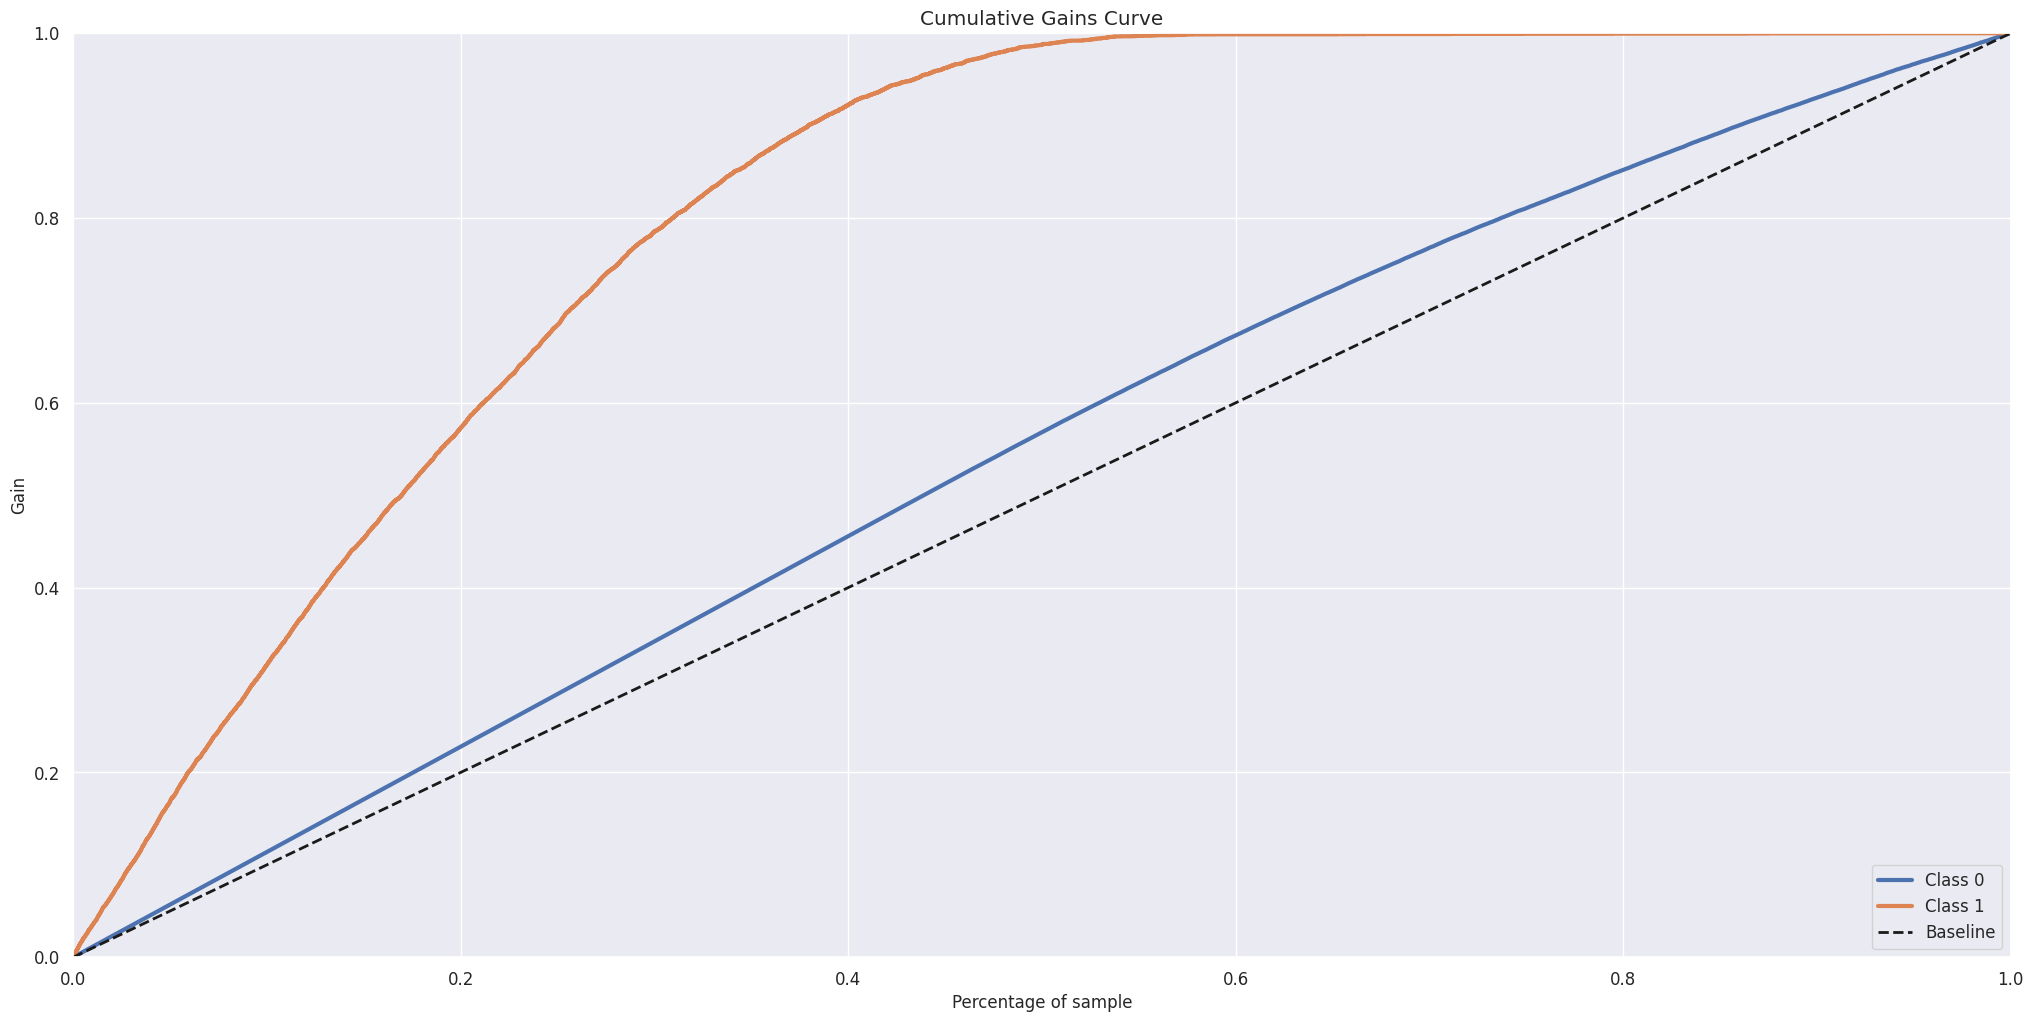

In [45]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_cat)

In [46]:
print(f'Precision at k: {precision_at_k(df7, yhat_cat)}')
print(f'Recall at k: {recall_at_k(df7, yhat_cat)}')

Precision at k: 0.3013349332533373
Recall at k: 0.8601398601398601


#### Cross Validation

In [47]:
cv_cat = cross_validation(cat_model, 5, X_train_cv, y_train_cv)
cv_cat

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

Learning rate set to 0.110541
0:	learn: 0.5125934	total: 61.5ms	remaining: 1m 1s
1:	learn: 0.4130301	total: 105ms	remaining: 52.6s
2:	learn: 0.3604445	total: 166ms	remaining: 55.3s
3:	learn: 0.3306041	total: 238ms	remaining: 59.3s
4:	learn: 0.3138103	total: 285ms	remaining: 56.8s
5:	learn: 0.3011612	total: 335ms	remaining: 55.5s
6:	learn: 0.2927506	total: 378ms	remaining: 53.7s
7:	learn: 0.2869673	total: 424ms	remaining: 52.6s
8:	learn: 0.2830856	total: 512ms	remaining: 56.4s
9:	learn: 0.2797555	total: 581ms	remaining: 57.5s
10:	learn: 0.2772354	total: 632ms	remaining: 56.8s
11:	learn: 0.2756190	total: 676ms	remaining: 55.6s
12:	learn: 0.2746693	total: 706ms	remaining: 53.6s
13:	learn: 0.2736152	total: 762ms	remaining: 53.6s
14:	learn: 0.2724765	total: 808ms	remaining: 53.1s
15:	learn: 0.2716002	total: 859ms	remaining: 52.8s
16:	learn: 0.2708762	total: 905ms	remaining: 52.3s
17:	learn: 0.2702975	total: 953ms	remaining: 52s
18:	learn: 0.2698617	total: 1s	remaining: 51.9s
19:	learn: 0.26

163:	learn: 0.2632422	total: 8.42s	remaining: 42.9s
164:	learn: 0.2632122	total: 8.47s	remaining: 42.9s
165:	learn: 0.2631849	total: 8.52s	remaining: 42.8s
166:	learn: 0.2631603	total: 8.57s	remaining: 42.7s
167:	learn: 0.2631339	total: 8.62s	remaining: 42.7s
168:	learn: 0.2631145	total: 8.68s	remaining: 42.7s
169:	learn: 0.2630957	total: 8.74s	remaining: 42.7s
170:	learn: 0.2630727	total: 8.79s	remaining: 42.6s
171:	learn: 0.2630498	total: 8.82s	remaining: 42.5s
172:	learn: 0.2630322	total: 8.87s	remaining: 42.4s
173:	learn: 0.2630142	total: 8.92s	remaining: 42.3s
174:	learn: 0.2629936	total: 8.98s	remaining: 42.4s
175:	learn: 0.2629804	total: 9.03s	remaining: 42.3s
176:	learn: 0.2629578	total: 9.07s	remaining: 42.2s
177:	learn: 0.2629331	total: 9.11s	remaining: 42.1s
178:	learn: 0.2629105	total: 9.17s	remaining: 42.1s
179:	learn: 0.2628937	total: 9.21s	remaining: 42s
180:	learn: 0.2628735	total: 9.27s	remaining: 41.9s
181:	learn: 0.2628628	total: 9.3s	remaining: 41.8s
182:	learn: 0.2

324:	learn: 0.2605041	total: 16.8s	remaining: 34.9s
325:	learn: 0.2604837	total: 16.9s	remaining: 34.8s
326:	learn: 0.2604655	total: 16.9s	remaining: 34.8s
327:	learn: 0.2604426	total: 17s	remaining: 34.8s
328:	learn: 0.2604240	total: 17s	remaining: 34.7s
329:	learn: 0.2604142	total: 17.1s	remaining: 34.7s
330:	learn: 0.2604009	total: 17.1s	remaining: 34.6s
331:	learn: 0.2603810	total: 17.2s	remaining: 34.5s
332:	learn: 0.2603632	total: 17.2s	remaining: 34.5s
333:	learn: 0.2603544	total: 17.3s	remaining: 34.4s
334:	learn: 0.2603401	total: 17.3s	remaining: 34.4s
335:	learn: 0.2603255	total: 17.4s	remaining: 34.3s
336:	learn: 0.2603157	total: 17.4s	remaining: 34.2s
337:	learn: 0.2602994	total: 17.5s	remaining: 34.2s
338:	learn: 0.2602854	total: 17.5s	remaining: 34.2s
339:	learn: 0.2602661	total: 17.6s	remaining: 34.2s
340:	learn: 0.2602425	total: 17.7s	remaining: 34.1s
341:	learn: 0.2602246	total: 17.7s	remaining: 34.1s
342:	learn: 0.2602133	total: 17.8s	remaining: 34s
343:	learn: 0.2601

486:	learn: 0.2581172	total: 25.1s	remaining: 26.4s
487:	learn: 0.2581030	total: 25.1s	remaining: 26.4s
488:	learn: 0.2580856	total: 25.2s	remaining: 26.3s
489:	learn: 0.2580687	total: 25.2s	remaining: 26.2s
490:	learn: 0.2580567	total: 25.3s	remaining: 26.2s
491:	learn: 0.2580390	total: 25.4s	remaining: 26.2s
492:	learn: 0.2580267	total: 25.4s	remaining: 26.1s
493:	learn: 0.2580109	total: 25.4s	remaining: 26.1s
494:	learn: 0.2579926	total: 25.5s	remaining: 26s
495:	learn: 0.2579791	total: 25.6s	remaining: 26s
496:	learn: 0.2579596	total: 25.6s	remaining: 25.9s
497:	learn: 0.2579469	total: 25.7s	remaining: 25.9s
498:	learn: 0.2579352	total: 25.7s	remaining: 25.8s
499:	learn: 0.2579247	total: 25.8s	remaining: 25.8s
500:	learn: 0.2579104	total: 25.8s	remaining: 25.7s
501:	learn: 0.2579017	total: 25.8s	remaining: 25.6s
502:	learn: 0.2578877	total: 25.9s	remaining: 25.6s
503:	learn: 0.2578768	total: 25.9s	remaining: 25.5s
504:	learn: 0.2578626	total: 26s	remaining: 25.5s
505:	learn: 0.2578

647:	learn: 0.2559445	total: 33.2s	remaining: 18s
648:	learn: 0.2559306	total: 33.2s	remaining: 18s
649:	learn: 0.2559184	total: 33.2s	remaining: 17.9s
650:	learn: 0.2558983	total: 33.3s	remaining: 17.8s
651:	learn: 0.2558820	total: 33.3s	remaining: 17.8s
652:	learn: 0.2558729	total: 33.4s	remaining: 17.8s
653:	learn: 0.2558612	total: 33.4s	remaining: 17.7s
654:	learn: 0.2558514	total: 33.5s	remaining: 17.6s
655:	learn: 0.2558362	total: 33.5s	remaining: 17.6s
656:	learn: 0.2558247	total: 33.6s	remaining: 17.5s
657:	learn: 0.2558022	total: 33.6s	remaining: 17.5s
658:	learn: 0.2557936	total: 33.7s	remaining: 17.4s
659:	learn: 0.2557794	total: 33.7s	remaining: 17.4s
660:	learn: 0.2557560	total: 33.8s	remaining: 17.3s
661:	learn: 0.2557390	total: 33.8s	remaining: 17.3s
662:	learn: 0.2557226	total: 33.9s	remaining: 17.2s
663:	learn: 0.2557060	total: 34s	remaining: 17.2s
664:	learn: 0.2556937	total: 34s	remaining: 17.1s
665:	learn: 0.2556808	total: 34.1s	remaining: 17.1s
666:	learn: 0.255660

808:	learn: 0.2539201	total: 41.4s	remaining: 9.77s
809:	learn: 0.2539133	total: 41.4s	remaining: 9.71s
810:	learn: 0.2539025	total: 41.5s	remaining: 9.66s
811:	learn: 0.2538909	total: 41.5s	remaining: 9.61s
812:	learn: 0.2538793	total: 41.5s	remaining: 9.55s
813:	learn: 0.2538689	total: 41.6s	remaining: 9.5s
814:	learn: 0.2538568	total: 41.6s	remaining: 9.45s
815:	learn: 0.2538448	total: 41.7s	remaining: 9.4s
816:	learn: 0.2538317	total: 41.7s	remaining: 9.35s
817:	learn: 0.2538196	total: 41.8s	remaining: 9.3s
818:	learn: 0.2538055	total: 41.8s	remaining: 9.25s
819:	learn: 0.2537937	total: 41.9s	remaining: 9.2s
820:	learn: 0.2537756	total: 42s	remaining: 9.15s
821:	learn: 0.2537589	total: 42s	remaining: 9.1s
822:	learn: 0.2537503	total: 42.1s	remaining: 9.05s
823:	learn: 0.2537359	total: 42.1s	remaining: 9s
824:	learn: 0.2537240	total: 42.2s	remaining: 8.95s
825:	learn: 0.2537128	total: 42.2s	remaining: 8.89s
826:	learn: 0.2536984	total: 42.3s	remaining: 8.84s
827:	learn: 0.2536862	to

967:	learn: 0.2519834	total: 49.4s	remaining: 1.63s
968:	learn: 0.2519714	total: 49.4s	remaining: 1.58s
969:	learn: 0.2519542	total: 49.5s	remaining: 1.53s
970:	learn: 0.2519325	total: 49.5s	remaining: 1.48s
971:	learn: 0.2519229	total: 49.6s	remaining: 1.43s
972:	learn: 0.2519137	total: 49.6s	remaining: 1.38s
973:	learn: 0.2519001	total: 49.7s	remaining: 1.33s
974:	learn: 0.2518893	total: 49.7s	remaining: 1.27s
975:	learn: 0.2518800	total: 49.8s	remaining: 1.22s
976:	learn: 0.2518710	total: 49.8s	remaining: 1.17s
977:	learn: 0.2518608	total: 49.9s	remaining: 1.12s
978:	learn: 0.2518459	total: 49.9s	remaining: 1.07s
979:	learn: 0.2518319	total: 50s	remaining: 1.02s
980:	learn: 0.2518215	total: 50s	remaining: 968ms
981:	learn: 0.2518120	total: 50s	remaining: 917ms
982:	learn: 0.2517983	total: 50.1s	remaining: 867ms
983:	learn: 0.2517815	total: 50.2s	remaining: 816ms
984:	learn: 0.2517640	total: 50.2s	remaining: 765ms
985:	learn: 0.2517475	total: 50.3s	remaining: 714ms
986:	learn: 0.2517

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

Learning rate set to 0.110541
0:	learn: 0.5131146	total: 41.8ms	remaining: 41.8s
1:	learn: 0.4138673	total: 90.4ms	remaining: 45.1s
2:	learn: 0.3606923	total: 134ms	remaining: 44.4s
3:	learn: 0.3303665	total: 187ms	remaining: 46.6s
4:	learn: 0.3145756	total: 230ms	remaining: 45.8s
5:	learn: 0.3017058	total: 288ms	remaining: 47.7s
6:	learn: 0.2941271	total: 330ms	remaining: 46.7s
7:	learn: 0.2890047	total: 378ms	remaining: 46.8s
8:	learn: 0.2841388	total: 431ms	remaining: 47.4s
9:	learn: 0.2811036	total: 479ms	remaining: 47.5s
10:	learn: 0.2784708	total: 527ms	remaining: 47.4s
11:	learn: 0.2771808	total: 561ms	remaining: 46.1s
12:	learn: 0.2752734	total: 613ms	remaining: 46.5s
13:	learn: 0.2741396	total: 669ms	remaining: 47.1s
14:	learn: 0.2730203	total: 744ms	remaining: 48.8s
15:	learn: 0.2725943	total: 783ms	remaining: 48.2s
16:	learn: 0.2719291	total: 827ms	remaining: 47.8s
17:	learn: 0.2711315	total: 886ms	remaining: 48.3s
18:	learn: 0.2707063	total: 929ms	remaining: 48s
19:	learn: 

163:	learn: 0.2634687	total: 8.59s	remaining: 43.8s
164:	learn: 0.2634394	total: 8.63s	remaining: 43.7s
165:	learn: 0.2634134	total: 8.68s	remaining: 43.6s
166:	learn: 0.2633946	total: 8.73s	remaining: 43.6s
167:	learn: 0.2633748	total: 8.82s	remaining: 43.7s
168:	learn: 0.2633505	total: 8.86s	remaining: 43.6s
169:	learn: 0.2633081	total: 8.92s	remaining: 43.6s
170:	learn: 0.2632898	total: 8.97s	remaining: 43.5s
171:	learn: 0.2632737	total: 9.02s	remaining: 43.4s
172:	learn: 0.2632607	total: 9.07s	remaining: 43.3s
173:	learn: 0.2632373	total: 9.12s	remaining: 43.3s
174:	learn: 0.2632249	total: 9.16s	remaining: 43.2s
175:	learn: 0.2632108	total: 9.2s	remaining: 43.1s
176:	learn: 0.2631866	total: 9.28s	remaining: 43.2s
177:	learn: 0.2631631	total: 9.35s	remaining: 43.2s
178:	learn: 0.2631390	total: 9.42s	remaining: 43.2s
179:	learn: 0.2631163	total: 9.48s	remaining: 43.2s
180:	learn: 0.2630812	total: 9.53s	remaining: 43.1s
181:	learn: 0.2630657	total: 9.57s	remaining: 43s
182:	learn: 0.2

323:	learn: 0.2606863	total: 16.8s	remaining: 35.1s
324:	learn: 0.2606660	total: 16.9s	remaining: 35.1s
325:	learn: 0.2606519	total: 17s	remaining: 35.1s
326:	learn: 0.2606327	total: 17s	remaining: 35s
327:	learn: 0.2606214	total: 17s	remaining: 34.9s
328:	learn: 0.2606034	total: 17.1s	remaining: 34.9s
329:	learn: 0.2605916	total: 17.2s	remaining: 34.8s
330:	learn: 0.2605809	total: 17.2s	remaining: 34.8s
331:	learn: 0.2605736	total: 17.3s	remaining: 34.7s
332:	learn: 0.2605610	total: 17.3s	remaining: 34.7s
333:	learn: 0.2605414	total: 17.4s	remaining: 34.6s
334:	learn: 0.2605237	total: 17.4s	remaining: 34.5s
335:	learn: 0.2605105	total: 17.4s	remaining: 34.5s
336:	learn: 0.2605009	total: 17.5s	remaining: 34.5s
337:	learn: 0.2604819	total: 17.6s	remaining: 34.4s
338:	learn: 0.2604575	total: 17.6s	remaining: 34.4s
339:	learn: 0.2604363	total: 17.7s	remaining: 34.4s
340:	learn: 0.2604241	total: 17.8s	remaining: 34.4s
341:	learn: 0.2603992	total: 17.8s	remaining: 34.3s
342:	learn: 0.260384

484:	learn: 0.2583492	total: 25.2s	remaining: 26.8s
485:	learn: 0.2583331	total: 25.3s	remaining: 26.7s
486:	learn: 0.2583249	total: 25.3s	remaining: 26.7s
487:	learn: 0.2583073	total: 25.4s	remaining: 26.6s
488:	learn: 0.2582916	total: 25.4s	remaining: 26.5s
489:	learn: 0.2582718	total: 25.5s	remaining: 26.5s
490:	learn: 0.2582646	total: 25.5s	remaining: 26.4s
491:	learn: 0.2582515	total: 25.5s	remaining: 26.4s
492:	learn: 0.2582400	total: 25.6s	remaining: 26.3s
493:	learn: 0.2582246	total: 25.6s	remaining: 26.3s
494:	learn: 0.2582139	total: 25.7s	remaining: 26.2s
495:	learn: 0.2581934	total: 25.7s	remaining: 26.2s
496:	learn: 0.2581787	total: 25.8s	remaining: 26.1s
497:	learn: 0.2581645	total: 25.8s	remaining: 26s
498:	learn: 0.2581533	total: 25.9s	remaining: 26s
499:	learn: 0.2581282	total: 25.9s	remaining: 25.9s
500:	learn: 0.2581138	total: 26s	remaining: 25.9s
501:	learn: 0.2580965	total: 26s	remaining: 25.8s
502:	learn: 0.2580885	total: 26.1s	remaining: 25.8s
503:	learn: 0.258074

644:	learn: 0.2562318	total: 33.3s	remaining: 18.4s
645:	learn: 0.2562215	total: 33.4s	remaining: 18.3s
646:	learn: 0.2562115	total: 33.4s	remaining: 18.2s
647:	learn: 0.2562060	total: 33.5s	remaining: 18.2s
648:	learn: 0.2561978	total: 33.5s	remaining: 18.1s
649:	learn: 0.2561840	total: 33.6s	remaining: 18.1s
650:	learn: 0.2561733	total: 33.6s	remaining: 18s
651:	learn: 0.2561584	total: 33.7s	remaining: 18s
652:	learn: 0.2561408	total: 33.7s	remaining: 17.9s
653:	learn: 0.2561299	total: 33.8s	remaining: 17.9s
654:	learn: 0.2561179	total: 33.8s	remaining: 17.8s
655:	learn: 0.2561022	total: 33.9s	remaining: 17.8s
656:	learn: 0.2560913	total: 33.9s	remaining: 17.7s
657:	learn: 0.2560741	total: 34s	remaining: 17.6s
658:	learn: 0.2560645	total: 34s	remaining: 17.6s
659:	learn: 0.2560540	total: 34s	remaining: 17.5s
660:	learn: 0.2560376	total: 34.1s	remaining: 17.5s
661:	learn: 0.2560254	total: 34.1s	remaining: 17.4s
662:	learn: 0.2560166	total: 34.2s	remaining: 17.4s
663:	learn: 0.2560016	

805:	learn: 0.2541960	total: 41.5s	remaining: 10s
806:	learn: 0.2541854	total: 41.6s	remaining: 9.95s
807:	learn: 0.2541756	total: 41.6s	remaining: 9.89s
808:	learn: 0.2541690	total: 41.7s	remaining: 9.84s
809:	learn: 0.2541553	total: 41.7s	remaining: 9.78s
810:	learn: 0.2541478	total: 41.8s	remaining: 9.73s
811:	learn: 0.2541392	total: 41.8s	remaining: 9.69s
812:	learn: 0.2541307	total: 41.9s	remaining: 9.64s
813:	learn: 0.2541212	total: 42s	remaining: 9.59s
814:	learn: 0.2541055	total: 42s	remaining: 9.54s
815:	learn: 0.2540905	total: 42.1s	remaining: 9.49s
816:	learn: 0.2540813	total: 42.2s	remaining: 9.44s
817:	learn: 0.2540727	total: 42.2s	remaining: 9.39s
818:	learn: 0.2540667	total: 42.3s	remaining: 9.34s
819:	learn: 0.2540560	total: 42.3s	remaining: 9.29s
820:	learn: 0.2540432	total: 42.4s	remaining: 9.24s
821:	learn: 0.2540355	total: 42.4s	remaining: 9.18s
822:	learn: 0.2540204	total: 42.5s	remaining: 9.13s
823:	learn: 0.2540108	total: 42.5s	remaining: 9.08s
824:	learn: 0.2540

968:	learn: 0.2523327	total: 49.9s	remaining: 1.6s
969:	learn: 0.2523246	total: 50s	remaining: 1.54s
970:	learn: 0.2523121	total: 50s	remaining: 1.49s
971:	learn: 0.2523039	total: 50s	remaining: 1.44s
972:	learn: 0.2522875	total: 50.1s	remaining: 1.39s
973:	learn: 0.2522747	total: 50.1s	remaining: 1.34s
974:	learn: 0.2522652	total: 50.2s	remaining: 1.29s
975:	learn: 0.2522529	total: 50.2s	remaining: 1.24s
976:	learn: 0.2522427	total: 50.3s	remaining: 1.18s
977:	learn: 0.2522270	total: 50.3s	remaining: 1.13s
978:	learn: 0.2522203	total: 50.4s	remaining: 1.08s
979:	learn: 0.2522092	total: 50.4s	remaining: 1.03s
980:	learn: 0.2522001	total: 50.5s	remaining: 977ms
981:	learn: 0.2521901	total: 50.5s	remaining: 926ms
982:	learn: 0.2521768	total: 50.6s	remaining: 875ms
983:	learn: 0.2521699	total: 50.6s	remaining: 823ms
984:	learn: 0.2521531	total: 50.7s	remaining: 772ms
985:	learn: 0.2521378	total: 50.7s	remaining: 720ms
986:	learn: 0.2521259	total: 50.8s	remaining: 669ms
987:	learn: 0.25210

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

Learning rate set to 0.110541
0:	learn: 0.5131414	total: 58.9ms	remaining: 58.8s
1:	learn: 0.4135692	total: 113ms	remaining: 56.2s
2:	learn: 0.3606298	total: 180ms	remaining: 59.7s
3:	learn: 0.3303474	total: 251ms	remaining: 1m 2s
4:	learn: 0.3146697	total: 286ms	remaining: 57s
5:	learn: 0.3017157	total: 330ms	remaining: 54.7s
6:	learn: 0.2930843	total: 381ms	remaining: 54.1s
7:	learn: 0.2875888	total: 423ms	remaining: 52.4s
8:	learn: 0.2834893	total: 482ms	remaining: 53.1s
9:	learn: 0.2801723	total: 528ms	remaining: 52.3s
10:	learn: 0.2776557	total: 583ms	remaining: 52.4s
11:	learn: 0.2758421	total: 629ms	remaining: 51.7s
12:	learn: 0.2745038	total: 680ms	remaining: 51.6s
13:	learn: 0.2732655	total: 736ms	remaining: 51.8s
14:	learn: 0.2724277	total: 799ms	remaining: 52.5s
15:	learn: 0.2715794	total: 845ms	remaining: 52s
16:	learn: 0.2710387	total: 896ms	remaining: 51.8s
17:	learn: 0.2704649	total: 941ms	remaining: 51.3s
18:	learn: 0.2701037	total: 991ms	remaining: 51.2s
19:	learn: 0.2

165:	learn: 0.2632085	total: 8.54s	remaining: 42.9s
166:	learn: 0.2631917	total: 8.59s	remaining: 42.8s
167:	learn: 0.2631706	total: 8.64s	remaining: 42.8s
168:	learn: 0.2631592	total: 8.68s	remaining: 42.7s
169:	learn: 0.2631321	total: 8.73s	remaining: 42.6s
170:	learn: 0.2631166	total: 8.78s	remaining: 42.6s
171:	learn: 0.2631032	total: 8.82s	remaining: 42.5s
172:	learn: 0.2630915	total: 8.86s	remaining: 42.4s
173:	learn: 0.2630732	total: 8.91s	remaining: 42.3s
174:	learn: 0.2630517	total: 8.96s	remaining: 42.2s
175:	learn: 0.2630345	total: 9.02s	remaining: 42.2s
176:	learn: 0.2630047	total: 9.06s	remaining: 42.1s
177:	learn: 0.2629854	total: 9.11s	remaining: 42.1s
178:	learn: 0.2629752	total: 9.15s	remaining: 42s
179:	learn: 0.2629517	total: 9.2s	remaining: 41.9s
180:	learn: 0.2629318	total: 9.25s	remaining: 41.9s
181:	learn: 0.2629047	total: 9.31s	remaining: 41.8s
182:	learn: 0.2628823	total: 9.37s	remaining: 41.8s
183:	learn: 0.2628689	total: 9.41s	remaining: 41.8s
184:	learn: 0.2

328:	learn: 0.2604578	total: 16.9s	remaining: 34.4s
329:	learn: 0.2604428	total: 16.9s	remaining: 34.4s
330:	learn: 0.2604318	total: 17s	remaining: 34.3s
331:	learn: 0.2604055	total: 17s	remaining: 34.3s
332:	learn: 0.2603872	total: 17.1s	remaining: 34.2s
333:	learn: 0.2603659	total: 17.1s	remaining: 34.1s
334:	learn: 0.2603479	total: 17.2s	remaining: 34.1s
335:	learn: 0.2603259	total: 17.2s	remaining: 34s
336:	learn: 0.2603062	total: 17.3s	remaining: 34s
337:	learn: 0.2602919	total: 17.3s	remaining: 33.9s
338:	learn: 0.2602784	total: 17.4s	remaining: 33.9s
339:	learn: 0.2602687	total: 17.4s	remaining: 33.8s
340:	learn: 0.2602504	total: 17.5s	remaining: 33.8s
341:	learn: 0.2602396	total: 17.5s	remaining: 33.7s
342:	learn: 0.2602200	total: 17.6s	remaining: 33.7s
343:	learn: 0.2602052	total: 17.6s	remaining: 33.6s
344:	learn: 0.2601916	total: 17.7s	remaining: 33.6s
345:	learn: 0.2601768	total: 17.7s	remaining: 33.5s
346:	learn: 0.2601579	total: 17.8s	remaining: 33.4s
347:	learn: 0.260144

488:	learn: 0.2580912	total: 26.2s	remaining: 27.4s
489:	learn: 0.2580820	total: 26.3s	remaining: 27.4s
490:	learn: 0.2580744	total: 26.3s	remaining: 27.3s
491:	learn: 0.2580613	total: 26.4s	remaining: 27.2s
492:	learn: 0.2580529	total: 26.4s	remaining: 27.2s
493:	learn: 0.2580390	total: 26.5s	remaining: 27.1s
494:	learn: 0.2580317	total: 26.5s	remaining: 27.1s
495:	learn: 0.2580190	total: 26.6s	remaining: 27s
496:	learn: 0.2580055	total: 26.6s	remaining: 27s
497:	learn: 0.2579950	total: 26.7s	remaining: 26.9s
498:	learn: 0.2579866	total: 26.7s	remaining: 26.8s
499:	learn: 0.2579795	total: 26.8s	remaining: 26.8s
500:	learn: 0.2579615	total: 26.8s	remaining: 26.7s
501:	learn: 0.2579502	total: 26.9s	remaining: 26.7s
502:	learn: 0.2579385	total: 26.9s	remaining: 26.6s
503:	learn: 0.2579241	total: 27s	remaining: 26.5s
504:	learn: 0.2579062	total: 27s	remaining: 26.5s
505:	learn: 0.2578847	total: 27.1s	remaining: 26.4s
506:	learn: 0.2578747	total: 27.1s	remaining: 26.4s
507:	learn: 0.257865

648:	learn: 0.2559997	total: 34.3s	remaining: 18.6s
649:	learn: 0.2559840	total: 34.4s	remaining: 18.5s
650:	learn: 0.2559725	total: 34.5s	remaining: 18.5s
651:	learn: 0.2559567	total: 34.5s	remaining: 18.4s
652:	learn: 0.2559440	total: 34.5s	remaining: 18.4s
653:	learn: 0.2559340	total: 34.6s	remaining: 18.3s
654:	learn: 0.2559193	total: 34.7s	remaining: 18.3s
655:	learn: 0.2559035	total: 34.7s	remaining: 18.2s
656:	learn: 0.2558980	total: 34.8s	remaining: 18.2s
657:	learn: 0.2558848	total: 34.8s	remaining: 18.1s
658:	learn: 0.2558691	total: 34.9s	remaining: 18.1s
659:	learn: 0.2558615	total: 35s	remaining: 18s
660:	learn: 0.2558506	total: 35s	remaining: 18s
661:	learn: 0.2558427	total: 35.1s	remaining: 17.9s
662:	learn: 0.2558292	total: 35.2s	remaining: 17.9s
663:	learn: 0.2558165	total: 35.2s	remaining: 17.8s
664:	learn: 0.2557959	total: 35.3s	remaining: 17.8s
665:	learn: 0.2557816	total: 35.4s	remaining: 17.7s
666:	learn: 0.2557699	total: 35.4s	remaining: 17.7s
667:	learn: 0.255761

808:	learn: 0.2540062	total: 43.9s	remaining: 10.4s
809:	learn: 0.2539948	total: 43.9s	remaining: 10.3s
810:	learn: 0.2539886	total: 44s	remaining: 10.2s
811:	learn: 0.2539804	total: 44s	remaining: 10.2s
812:	learn: 0.2539613	total: 44.1s	remaining: 10.1s
813:	learn: 0.2539503	total: 44.1s	remaining: 10.1s
814:	learn: 0.2539395	total: 44.2s	remaining: 10s
815:	learn: 0.2539276	total: 44.3s	remaining: 9.98s
816:	learn: 0.2539179	total: 44.3s	remaining: 9.93s
817:	learn: 0.2539095	total: 44.4s	remaining: 9.88s
818:	learn: 0.2538993	total: 44.5s	remaining: 9.83s
819:	learn: 0.2538866	total: 44.5s	remaining: 9.78s
820:	learn: 0.2538797	total: 44.6s	remaining: 9.73s
821:	learn: 0.2538716	total: 44.7s	remaining: 9.68s
822:	learn: 0.2538661	total: 44.7s	remaining: 9.62s
823:	learn: 0.2538533	total: 44.8s	remaining: 9.57s
824:	learn: 0.2538468	total: 44.9s	remaining: 9.51s
825:	learn: 0.2538302	total: 44.9s	remaining: 9.46s
826:	learn: 0.2538225	total: 44.9s	remaining: 9.4s
827:	learn: 0.25380

967:	learn: 0.2521428	total: 52.2s	remaining: 1.73s
968:	learn: 0.2521300	total: 52.2s	remaining: 1.67s
969:	learn: 0.2521172	total: 52.3s	remaining: 1.62s
970:	learn: 0.2521093	total: 52.3s	remaining: 1.56s
971:	learn: 0.2521006	total: 52.4s	remaining: 1.51s
972:	learn: 0.2520895	total: 52.4s	remaining: 1.45s
973:	learn: 0.2520828	total: 52.5s	remaining: 1.4s
974:	learn: 0.2520767	total: 52.5s	remaining: 1.35s
975:	learn: 0.2520655	total: 52.6s	remaining: 1.29s
976:	learn: 0.2520525	total: 52.6s	remaining: 1.24s
977:	learn: 0.2520413	total: 52.7s	remaining: 1.18s
978:	learn: 0.2520350	total: 52.7s	remaining: 1.13s
979:	learn: 0.2520189	total: 52.8s	remaining: 1.08s
980:	learn: 0.2520011	total: 52.8s	remaining: 1.02s
981:	learn: 0.2519903	total: 52.9s	remaining: 969ms
982:	learn: 0.2519785	total: 52.9s	remaining: 915ms
983:	learn: 0.2519686	total: 53s	remaining: 861ms
984:	learn: 0.2519565	total: 53s	remaining: 807ms
985:	learn: 0.2519500	total: 53s	remaining: 753ms
986:	learn: 0.25193

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

Learning rate set to 0.110541
0:	learn: 0.5135154	total: 48.4ms	remaining: 48.4s
1:	learn: 0.4145898	total: 94.9ms	remaining: 47.4s
2:	learn: 0.3615342	total: 146ms	remaining: 48.6s
3:	learn: 0.3313086	total: 193ms	remaining: 48s
4:	learn: 0.3154565	total: 234ms	remaining: 46.6s
5:	learn: 0.3024302	total: 287ms	remaining: 47.6s
6:	learn: 0.2946190	total: 342ms	remaining: 48.6s
7:	learn: 0.2894408	total: 407ms	remaining: 50.4s
8:	learn: 0.2845085	total: 480ms	remaining: 52.8s
9:	learn: 0.2813231	total: 523ms	remaining: 51.7s
10:	learn: 0.2786759	total: 579ms	remaining: 52s
11:	learn: 0.2768395	total: 653ms	remaining: 53.8s
12:	learn: 0.2756629	total: 712ms	remaining: 54s
13:	learn: 0.2744989	total: 787ms	remaining: 55.4s
14:	learn: 0.2731763	total: 833ms	remaining: 54.7s
15:	learn: 0.2723058	total: 901ms	remaining: 55.4s
16:	learn: 0.2717479	total: 969ms	remaining: 56s
17:	learn: 0.2711731	total: 1.01s	remaining: 55.3s
18:	learn: 0.2704403	total: 1.06s	remaining: 55s
19:	learn: 0.270018

164:	learn: 0.2635358	total: 8.62s	remaining: 43.6s
165:	learn: 0.2635182	total: 8.68s	remaining: 43.6s
166:	learn: 0.2635074	total: 8.72s	remaining: 43.5s
167:	learn: 0.2634812	total: 8.77s	remaining: 43.4s
168:	learn: 0.2634602	total: 8.82s	remaining: 43.4s
169:	learn: 0.2634453	total: 8.88s	remaining: 43.4s
170:	learn: 0.2634190	total: 8.92s	remaining: 43.3s
171:	learn: 0.2634050	total: 8.96s	remaining: 43.1s
172:	learn: 0.2633890	total: 9.01s	remaining: 43.1s
173:	learn: 0.2633576	total: 9.06s	remaining: 43s
174:	learn: 0.2633392	total: 9.12s	remaining: 43s
175:	learn: 0.2633259	total: 9.16s	remaining: 42.9s
176:	learn: 0.2633079	total: 9.21s	remaining: 42.8s
177:	learn: 0.2632870	total: 9.25s	remaining: 42.7s
178:	learn: 0.2632698	total: 9.31s	remaining: 42.7s
179:	learn: 0.2632512	total: 9.35s	remaining: 42.6s
180:	learn: 0.2632359	total: 9.4s	remaining: 42.5s
181:	learn: 0.2632127	total: 9.44s	remaining: 42.4s
182:	learn: 0.2632009	total: 9.48s	remaining: 42.3s
183:	learn: 0.263

325:	learn: 0.2608911	total: 17s	remaining: 35.1s
326:	learn: 0.2608766	total: 17s	remaining: 35s
327:	learn: 0.2608673	total: 17.1s	remaining: 34.9s
328:	learn: 0.2608511	total: 17.1s	remaining: 34.9s
329:	learn: 0.2608277	total: 17.1s	remaining: 34.8s
330:	learn: 0.2608098	total: 17.2s	remaining: 34.8s
331:	learn: 0.2607917	total: 17.2s	remaining: 34.7s
332:	learn: 0.2607753	total: 17.3s	remaining: 34.6s
333:	learn: 0.2607570	total: 17.3s	remaining: 34.5s
334:	learn: 0.2607292	total: 17.4s	remaining: 34.5s
335:	learn: 0.2607140	total: 17.4s	remaining: 34.4s
336:	learn: 0.2606828	total: 17.5s	remaining: 34.4s
337:	learn: 0.2606688	total: 17.5s	remaining: 34.3s
338:	learn: 0.2606571	total: 17.5s	remaining: 34.2s
339:	learn: 0.2606444	total: 17.6s	remaining: 34.2s
340:	learn: 0.2606235	total: 17.7s	remaining: 34.2s
341:	learn: 0.2606106	total: 17.7s	remaining: 34.1s
342:	learn: 0.2605842	total: 17.8s	remaining: 34.1s
343:	learn: 0.2605723	total: 17.8s	remaining: 34s
344:	learn: 0.260558

486:	learn: 0.2585112	total: 25.6s	remaining: 27s
487:	learn: 0.2584970	total: 25.7s	remaining: 26.9s
488:	learn: 0.2584787	total: 25.8s	remaining: 26.9s
489:	learn: 0.2584621	total: 25.8s	remaining: 26.9s
490:	learn: 0.2584427	total: 25.9s	remaining: 26.8s
491:	learn: 0.2584269	total: 25.9s	remaining: 26.8s
492:	learn: 0.2584088	total: 26s	remaining: 26.7s
493:	learn: 0.2583994	total: 26.1s	remaining: 26.7s
494:	learn: 0.2583921	total: 26.1s	remaining: 26.6s
495:	learn: 0.2583806	total: 26.2s	remaining: 26.6s
496:	learn: 0.2583577	total: 26.3s	remaining: 26.6s
497:	learn: 0.2583471	total: 26.3s	remaining: 26.5s
498:	learn: 0.2583313	total: 26.4s	remaining: 26.5s
499:	learn: 0.2583208	total: 26.4s	remaining: 26.4s
500:	learn: 0.2583091	total: 26.5s	remaining: 26.3s
501:	learn: 0.2582999	total: 26.5s	remaining: 26.3s
502:	learn: 0.2582896	total: 26.5s	remaining: 26.2s
503:	learn: 0.2582775	total: 26.6s	remaining: 26.2s
504:	learn: 0.2582621	total: 26.6s	remaining: 26.1s
505:	learn: 0.25

649:	learn: 0.2563433	total: 34.1s	remaining: 18.4s
650:	learn: 0.2563333	total: 34.2s	remaining: 18.3s
651:	learn: 0.2563281	total: 34.2s	remaining: 18.3s
652:	learn: 0.2563129	total: 34.3s	remaining: 18.2s
653:	learn: 0.2563059	total: 34.3s	remaining: 18.2s
654:	learn: 0.2562892	total: 34.4s	remaining: 18.1s
655:	learn: 0.2562781	total: 34.4s	remaining: 18.1s
656:	learn: 0.2562682	total: 34.5s	remaining: 18s
657:	learn: 0.2562537	total: 34.5s	remaining: 17.9s
658:	learn: 0.2562363	total: 34.6s	remaining: 17.9s
659:	learn: 0.2562272	total: 34.6s	remaining: 17.8s
660:	learn: 0.2562134	total: 34.7s	remaining: 17.8s
661:	learn: 0.2561966	total: 34.8s	remaining: 17.7s
662:	learn: 0.2561853	total: 34.8s	remaining: 17.7s
663:	learn: 0.2561719	total: 34.9s	remaining: 17.6s
664:	learn: 0.2561536	total: 34.9s	remaining: 17.6s
665:	learn: 0.2561406	total: 34.9s	remaining: 17.5s
666:	learn: 0.2561267	total: 35s	remaining: 17.5s
667:	learn: 0.2561142	total: 35s	remaining: 17.4s
668:	learn: 0.2561

811:	learn: 0.2542566	total: 42.5s	remaining: 9.83s
812:	learn: 0.2542503	total: 42.5s	remaining: 9.78s
813:	learn: 0.2542352	total: 42.6s	remaining: 9.72s
814:	learn: 0.2542242	total: 42.6s	remaining: 9.67s
815:	learn: 0.2542098	total: 42.7s	remaining: 9.62s
816:	learn: 0.2541991	total: 42.7s	remaining: 9.57s
817:	learn: 0.2541866	total: 42.8s	remaining: 9.51s
818:	learn: 0.2541760	total: 42.8s	remaining: 9.46s
819:	learn: 0.2541635	total: 42.8s	remaining: 9.4s
820:	learn: 0.2541516	total: 42.9s	remaining: 9.35s
821:	learn: 0.2541395	total: 43s	remaining: 9.3s
822:	learn: 0.2541309	total: 43s	remaining: 9.25s
823:	learn: 0.2541176	total: 43.1s	remaining: 9.2s
824:	learn: 0.2541078	total: 43.1s	remaining: 9.14s
825:	learn: 0.2540932	total: 43.1s	remaining: 9.09s
826:	learn: 0.2540789	total: 43.2s	remaining: 9.04s
827:	learn: 0.2540671	total: 43.2s	remaining: 8.98s
828:	learn: 0.2540572	total: 43.3s	remaining: 8.93s
829:	learn: 0.2540480	total: 43.3s	remaining: 8.88s
830:	learn: 0.25403

972:	learn: 0.2523827	total: 50.6s	remaining: 1.4s
973:	learn: 0.2523684	total: 50.6s	remaining: 1.35s
974:	learn: 0.2523561	total: 50.7s	remaining: 1.3s
975:	learn: 0.2523379	total: 50.7s	remaining: 1.25s
976:	learn: 0.2523219	total: 50.8s	remaining: 1.2s
977:	learn: 0.2523102	total: 50.8s	remaining: 1.14s
978:	learn: 0.2522951	total: 50.9s	remaining: 1.09s
979:	learn: 0.2522846	total: 50.9s	remaining: 1.04s
980:	learn: 0.2522793	total: 51s	remaining: 987ms
981:	learn: 0.2522702	total: 51s	remaining: 935ms
982:	learn: 0.2522587	total: 51.1s	remaining: 883ms
983:	learn: 0.2522440	total: 51.1s	remaining: 831ms
984:	learn: 0.2522259	total: 51.2s	remaining: 779ms
985:	learn: 0.2522174	total: 51.2s	remaining: 727ms
986:	learn: 0.2522026	total: 51.3s	remaining: 675ms
987:	learn: 0.2521895	total: 51.3s	remaining: 623ms
988:	learn: 0.2521772	total: 51.4s	remaining: 571ms
989:	learn: 0.2521657	total: 51.4s	remaining: 519ms
990:	learn: 0.2521590	total: 51.5s	remaining: 467ms
991:	learn: 0.25214

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

Learning rate set to 0.110541
0:	learn: 0.5136705	total: 44.2ms	remaining: 44.1s
1:	learn: 0.4148995	total: 89.5ms	remaining: 44.7s
2:	learn: 0.3613546	total: 135ms	remaining: 44.9s
3:	learn: 0.3309567	total: 181ms	remaining: 45.1s
4:	learn: 0.3138433	total: 258ms	remaining: 51.3s
5:	learn: 0.3013736	total: 332ms	remaining: 55.1s
6:	learn: 0.2932541	total: 377ms	remaining: 53.4s
7:	learn: 0.2873694	total: 424ms	remaining: 52.5s
8:	learn: 0.2834333	total: 476ms	remaining: 52.5s
9:	learn: 0.2801214	total: 522ms	remaining: 51.7s
10:	learn: 0.2777738	total: 575ms	remaining: 51.7s
11:	learn: 0.2763279	total: 622ms	remaining: 51.2s
12:	learn: 0.2745878	total: 670ms	remaining: 50.9s
13:	learn: 0.2729662	total: 730ms	remaining: 51.4s
14:	learn: 0.2720956	total: 778ms	remaining: 51.1s
15:	learn: 0.2714405	total: 820ms	remaining: 50.5s
16:	learn: 0.2708098	total: 870ms	remaining: 50.3s
17:	learn: 0.2703756	total: 924ms	remaining: 50.4s
18:	learn: 0.2700123	total: 988ms	remaining: 51s
19:	learn: 

162:	learn: 0.2632548	total: 8.35s	remaining: 42.9s
163:	learn: 0.2632396	total: 8.4s	remaining: 42.8s
164:	learn: 0.2632257	total: 8.44s	remaining: 42.7s
165:	learn: 0.2632017	total: 8.48s	remaining: 42.6s
166:	learn: 0.2631800	total: 8.53s	remaining: 42.5s
167:	learn: 0.2631623	total: 8.59s	remaining: 42.5s
168:	learn: 0.2631420	total: 8.66s	remaining: 42.6s
169:	learn: 0.2631197	total: 8.7s	remaining: 42.5s
170:	learn: 0.2631002	total: 8.74s	remaining: 42.4s
171:	learn: 0.2630820	total: 8.79s	remaining: 42.3s
172:	learn: 0.2630562	total: 8.84s	remaining: 42.3s
173:	learn: 0.2630397	total: 8.9s	remaining: 42.2s
174:	learn: 0.2630167	total: 8.94s	remaining: 42.1s
175:	learn: 0.2629914	total: 8.99s	remaining: 42.1s
176:	learn: 0.2629758	total: 9.03s	remaining: 42s
177:	learn: 0.2629621	total: 9.09s	remaining: 42s
178:	learn: 0.2629350	total: 9.13s	remaining: 41.9s
179:	learn: 0.2629211	total: 9.17s	remaining: 41.8s
180:	learn: 0.2629016	total: 9.21s	remaining: 41.7s
181:	learn: 0.26288

322:	learn: 0.2604997	total: 16.4s	remaining: 34.3s
323:	learn: 0.2604860	total: 16.4s	remaining: 34.2s
324:	learn: 0.2604729	total: 16.4s	remaining: 34.2s
325:	learn: 0.2604524	total: 16.5s	remaining: 34.1s
326:	learn: 0.2604368	total: 16.5s	remaining: 34s
327:	learn: 0.2604164	total: 16.6s	remaining: 34s
328:	learn: 0.2604030	total: 16.6s	remaining: 33.9s
329:	learn: 0.2603855	total: 16.7s	remaining: 33.9s
330:	learn: 0.2603673	total: 16.7s	remaining: 33.8s
331:	learn: 0.2603540	total: 16.8s	remaining: 33.8s
332:	learn: 0.2603523	total: 16.8s	remaining: 33.7s
333:	learn: 0.2603391	total: 16.9s	remaining: 33.7s
334:	learn: 0.2603253	total: 16.9s	remaining: 33.6s
335:	learn: 0.2603172	total: 17s	remaining: 33.5s
336:	learn: 0.2602983	total: 17s	remaining: 33.5s
337:	learn: 0.2602839	total: 17.1s	remaining: 33.4s
338:	learn: 0.2602632	total: 17.1s	remaining: 33.4s
339:	learn: 0.2602471	total: 17.2s	remaining: 33.3s
340:	learn: 0.2602457	total: 17.2s	remaining: 33.2s
341:	learn: 0.260236

483:	learn: 0.2581833	total: 24.7s	remaining: 26.3s
484:	learn: 0.2581734	total: 24.7s	remaining: 26.2s
485:	learn: 0.2581524	total: 24.8s	remaining: 26.2s
486:	learn: 0.2581361	total: 24.8s	remaining: 26.2s
487:	learn: 0.2581216	total: 24.9s	remaining: 26.1s
488:	learn: 0.2581094	total: 24.9s	remaining: 26.1s
489:	learn: 0.2580896	total: 25s	remaining: 26s
490:	learn: 0.2580799	total: 25s	remaining: 25.9s
491:	learn: 0.2580659	total: 25.1s	remaining: 25.9s
492:	learn: 0.2580486	total: 25.1s	remaining: 25.8s
493:	learn: 0.2580366	total: 25.2s	remaining: 25.8s
494:	learn: 0.2580275	total: 25.2s	remaining: 25.7s
495:	learn: 0.2580182	total: 25.3s	remaining: 25.7s
496:	learn: 0.2580026	total: 25.3s	remaining: 25.6s
497:	learn: 0.2579896	total: 25.4s	remaining: 25.6s
498:	learn: 0.2579714	total: 25.4s	remaining: 25.5s
499:	learn: 0.2579455	total: 25.4s	remaining: 25.4s
500:	learn: 0.2579415	total: 25.5s	remaining: 25.4s
501:	learn: 0.2579293	total: 25.5s	remaining: 25.3s
502:	learn: 0.2579

644:	learn: 0.2560494	total: 33s	remaining: 18.1s
645:	learn: 0.2560387	total: 33s	remaining: 18.1s
646:	learn: 0.2560210	total: 33.1s	remaining: 18s
647:	learn: 0.2560096	total: 33.1s	remaining: 18s
648:	learn: 0.2559946	total: 33.1s	remaining: 17.9s
649:	learn: 0.2559854	total: 33.2s	remaining: 17.9s
650:	learn: 0.2559673	total: 33.2s	remaining: 17.8s
651:	learn: 0.2559545	total: 33.3s	remaining: 17.8s
652:	learn: 0.2559337	total: 33.3s	remaining: 17.7s
653:	learn: 0.2559159	total: 33.4s	remaining: 17.7s
654:	learn: 0.2559046	total: 33.4s	remaining: 17.6s
655:	learn: 0.2558927	total: 33.5s	remaining: 17.6s
656:	learn: 0.2558853	total: 33.5s	remaining: 17.5s
657:	learn: 0.2558693	total: 33.6s	remaining: 17.5s
658:	learn: 0.2558514	total: 33.7s	remaining: 17.4s
659:	learn: 0.2558391	total: 33.7s	remaining: 17.4s
660:	learn: 0.2558236	total: 33.8s	remaining: 17.3s
661:	learn: 0.2558154	total: 33.8s	remaining: 17.3s
662:	learn: 0.2557986	total: 33.9s	remaining: 17.2s
663:	learn: 0.255787

807:	learn: 0.2540168	total: 41.2s	remaining: 9.8s
808:	learn: 0.2540084	total: 41.3s	remaining: 9.75s
809:	learn: 0.2539995	total: 41.3s	remaining: 9.69s
810:	learn: 0.2539834	total: 41.4s	remaining: 9.65s
811:	learn: 0.2539709	total: 41.5s	remaining: 9.6s
812:	learn: 0.2539545	total: 41.5s	remaining: 9.55s
813:	learn: 0.2539407	total: 41.6s	remaining: 9.49s
814:	learn: 0.2539283	total: 41.6s	remaining: 9.44s
815:	learn: 0.2539143	total: 41.6s	remaining: 9.39s
816:	learn: 0.2539013	total: 41.7s	remaining: 9.34s
817:	learn: 0.2538934	total: 41.8s	remaining: 9.29s
818:	learn: 0.2538863	total: 41.8s	remaining: 9.24s
819:	learn: 0.2538667	total: 41.8s	remaining: 9.18s
820:	learn: 0.2538586	total: 41.9s	remaining: 9.13s
821:	learn: 0.2538463	total: 42s	remaining: 9.09s
822:	learn: 0.2538342	total: 42s	remaining: 9.04s
823:	learn: 0.2538268	total: 42.1s	remaining: 8.99s
824:	learn: 0.2538196	total: 42.1s	remaining: 8.94s
825:	learn: 0.2538089	total: 42.2s	remaining: 8.89s
826:	learn: 0.2537

967:	learn: 0.2521591	total: 49.4s	remaining: 1.63s
968:	learn: 0.2521482	total: 49.5s	remaining: 1.58s
969:	learn: 0.2521368	total: 49.5s	remaining: 1.53s
970:	learn: 0.2521273	total: 49.6s	remaining: 1.48s
971:	learn: 0.2521183	total: 49.6s	remaining: 1.43s
972:	learn: 0.2521080	total: 49.7s	remaining: 1.38s
973:	learn: 0.2520984	total: 49.7s	remaining: 1.33s
974:	learn: 0.2520864	total: 49.8s	remaining: 1.27s
975:	learn: 0.2520790	total: 49.8s	remaining: 1.23s
976:	learn: 0.2520661	total: 49.9s	remaining: 1.17s
977:	learn: 0.2520507	total: 50s	remaining: 1.12s
978:	learn: 0.2520379	total: 50s	remaining: 1.07s
979:	learn: 0.2520264	total: 50.1s	remaining: 1.02s
980:	learn: 0.2520122	total: 50.1s	remaining: 970ms
981:	learn: 0.2520056	total: 50.1s	remaining: 919ms
982:	learn: 0.2520012	total: 50.2s	remaining: 868ms
983:	learn: 0.2519920	total: 50.2s	remaining: 817ms
984:	learn: 0.2519841	total: 50.3s	remaining: 766ms
985:	learn: 0.2519668	total: 50.3s	remaining: 715ms
986:	learn: 0.25

,Model,Precision at k,Recall at k
0,CatBoostClassifier,0.3161+/-0.0011,0.7963+/-0.0027


## 7.2 Model Performance

In [48]:
performance = pd.concat([cv_knn, cv_lr, cv_rf, cv_xgb, cv_lgbm, cv_cat])
performance.sort_values('Recall at k', ascending=False)

,Model,Precision at k,Recall at k
0,LGBMClassifier,0.3167+/-0.0004,0.7976+/-0.0009
0,CatBoostClassifier,0.3161+/-0.0011,0.7963+/-0.0027
0,XGBClassifier,0.3158+/-0.0007,0.7954+/-0.0017
0,RandomForestClassifier,0.2965+/-0.0006,0.7469+/-0.0016
0,KNeighborsClassifier,0.2872+/-0.0013,0.7233+/-0.0034
0,LogisticRegression,0.2798+/-0.0018,0.7048+/-0.0046


# 8.0 HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [51]:
param = {'n_estimators': [400, 650, 800, 1200],
          'learning_rate': [0.01, 0.05, 0.1],
          'max_depth': [7, 9, 13, 18],
          'num_leaves': [30, 55, 75, 85, 120],
          'min_child_samples': [20, 80, 120, 200]}

max_eval = 20

In [54]:
final_result = pd.DataFrame()
parameters_list = []

for i in range(max_eval):
    #choose values for parameters randomly
    hp = {k: sample(v, 1)[0] for k, v in param.items()}
    parameters_list.append(hp)
    print(i)
    print(hp)
    
    # model
    model_lgbm = LGBMClassifier(n_estimators=hp['n_estimators'],
                                learning_rate=hp['learning_rate'],
                                max_depth=hp['max_depth'],
                                num_leaves=hp['num_leaves'],
                                min_child_samples=hp['min_child_samples'],
                                n_jobs=-1)

    # performance
    result = cross_validation(model_lgbm, 5, X_train_cv, y_train_cv)
    final_result = pd.concat([final_result, result])
final_result['parameters'] = parameters_list

0
{'n_estimators': 400, 'learning_rate': 0.01, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 200}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

1
{'n_estimators': 400, 'learning_rate': 0.05, 'max_depth': 18, 'num_leaves': 30, 'min_child_samples': 20}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

2
{'n_estimators': 400, 'learning_rate': 0.01, 'max_depth': 9, 'num_leaves': 75, 'min_child_samples': 120}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

3
{'n_estimators': 1200, 'learning_rate': 0.05, 'max_depth': 18, 'num_leaves': 55, 'min_child_samples': 80}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/feature_engine/encoding/base_encoder.py:210: UserWarning: During the encoding, NaN values were introduced in the feature(s) policy_sales_channel.
  warnings.warn(
/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold

4
{'n_estimators': 1200, 'learning_rate': 0.01, 'max_depth': 13, 'num_leaves': 85, 'min_child_samples': 200}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['policy_sales_channel'] = X_train_fold['policy_sales_channel'].astype(str)
/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

5
{'n_estimators': 1200, 'learning_rate': 0.01, 'max_depth': 7, 'num_leaves': 120, 'min_child_samples': 200}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['policy_sales_channel'] = X_train_fold['policy_sales_channel'].astype(str)
/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

6
{'n_estimators': 800, 'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 75, 'min_child_samples': 200}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

7
{'n_estimators': 800, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 85, 'min_child_samples': 120}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

8
{'n_estimators': 800, 'learning_rate': 0.01, 'max_depth': 7, 'num_leaves': 55, 'min_child_samples': 20}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['policy_sales_channel'] = X_test_fold['policy_sales_channel'].astype(str)
/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/feature_engine/encoding/base_encoder.py:210: UserWarning: During the encoding, NaN values were introduced in the feature(s) policy_sales_channel.
  warnings.warn(
/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['an

9
{'n_estimators': 400, 'learning_rate': 0.05, 'max_depth': 13, 'num_leaves': 75, 'min_child_samples': 120}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['policy_sales_channel'] = X_train_fold['policy_sales_channel'].astype(str)
/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/feature_engine/encoding/base_encoder.py:210: UserWarning: During the encoding, NaN values were introduced in the feature(s) policy_sales_channel.
  warnings.warn(
/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold

10
{'n_estimators': 400, 'learning_rate': 0.01, 'max_depth': 9, 'num_leaves': 55, 'min_child_samples': 200}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['policy_sales_channel'] = X_train_fold['policy_sales_channel'].astype(str)
/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/feature_engine/encoding/base_encoder.py:210: UserWarning: During the encoding, NaN values were introduced in the feature(s) policy_sales_channel.
  warnings.warn(
/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold

11
{'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 13, 'num_leaves': 75, 'min_child_samples': 200}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/feature_engine/encoding/base_encoder.py:210: UserWarning: During the encoding, NaN values were introduced in the feature(s) policy_sales_channel.
  warnings.warn(
/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold

12
{'n_estimators': 650, 'learning_rate': 0.01, 'max_depth': 7, 'num_leaves': 85, 'min_child_samples': 200}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['policy_sales_channel'] = X_train_fold['policy_sales_channel'].astype(str)
/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/feature_engine/encoding/base_encoder.py:210: UserWarning: During the encoding, NaN values were introduced in the feature(s) policy_sales_channel.
  warnings.warn(
/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold

13
{'n_estimators': 800, 'learning_rate': 0.01, 'max_depth': 18, 'num_leaves': 120, 'min_child_samples': 80}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

14
{'n_estimators': 800, 'learning_rate': 0.01, 'max_depth': 13, 'num_leaves': 85, 'min_child_samples': 80}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

15
{'n_estimators': 800, 'learning_rate': 0.01, 'max_depth': 9, 'num_leaves': 75, 'min_child_samples': 80}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

16
{'n_estimators': 400, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 30, 'min_child_samples': 120}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

17
{'n_estimators': 1200, 'learning_rate': 0.05, 'max_depth': 9, 'num_leaves': 55, 'min_child_samples': 20}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

18
{'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 85, 'min_child_samples': 80}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

19
{'n_estimators': 400, 'learning_rate': 0.05, 'max_depth': 13, 'num_leaves': 120, 'min_child_samples': 200}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [59]:
# Ordenando por maior Recall at k
final_result.reset_index().sort_values('Recall at k', ascending=False)

,index,Model,Precision at k,Recall at k,parameters
5,0,LGBMClassifier,0.3176+/-0.001,0.8+/-0.0026,"{'n_estimators': 1200, 'learning_rate': 0.01, ..."
8,0,LGBMClassifier,0.3175+/-0.0009,0.7997+/-0.0023,"{'n_estimators': 800, 'learning_rate': 0.01, '..."
15,0,LGBMClassifier,0.3174+/-0.0012,0.7994+/-0.003,"{'n_estimators': 800, 'learning_rate': 0.01, '..."
12,0,LGBMClassifier,0.3173+/-0.0009,0.7993+/-0.0024,"{'n_estimators': 650, 'learning_rate': 0.01, '..."
13,0,LGBMClassifier,0.3173+/-0.0012,0.7992+/-0.003,"{'n_estimators': 800, 'learning_rate': 0.01, '..."
10,0,LGBMClassifier,0.3173+/-0.0009,0.7992+/-0.0023,"{'n_estimators': 400, 'learning_rate': 0.01, '..."
14,0,LGBMClassifier,0.3172+/-0.001,0.7989+/-0.0025,"{'n_estimators': 800, 'learning_rate': 0.01, '..."
2,0,LGBMClassifier,0.3172+/-0.001,0.7989+/-0.0024,"{'n_estimators': 400, 'learning_rate': 0.01, '..."
4,0,LGBMClassifier,0.317+/-0.001,0.7985+/-0.0024,"{'n_estimators': 1200, 'learning_rate': 0.01, ..."
16,0,LGBMClassifier,0.3168+/-0.0009,0.7979+/-0.0023,"{'n_estimators': 400, 'learning_rate': 0.05, '..."


In [67]:
# Melhores parâmetros
final_result.reset_index().loc[5, 'parameters']

{'n_estimators': 1200,
 'learning_rate': 0.01,
 'max_depth': 7,
 'num_leaves': 120,
 'min_child_samples': 200}

## 8.2 Treino do modelo com parâmetros otimizados

In [68]:
# Model with tunned parameters
model_lgbm = LGBMClassifier(n_estimators=1200, 
                            learning_rate=0.01,
                            max_depth=7,
                            num_leaves=120,
                            min_child_samples=200)
# training with train dataset
model_lgbm.fit(X_train, y_train)

# Predicting propensity
yhat_lgbm_tunned = model_lgbm.predict_proba(X_val)

In [69]:
print(f'Precision at k: {precision_at_k(df7, yhat_lgbm_tunned)}')
print(f'Recall at k: {recall_at_k(df7, yhat_lgbm_tunned)}')

Precision at k: 0.3030848457577121
Recall at k: 0.8651348651348651


<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

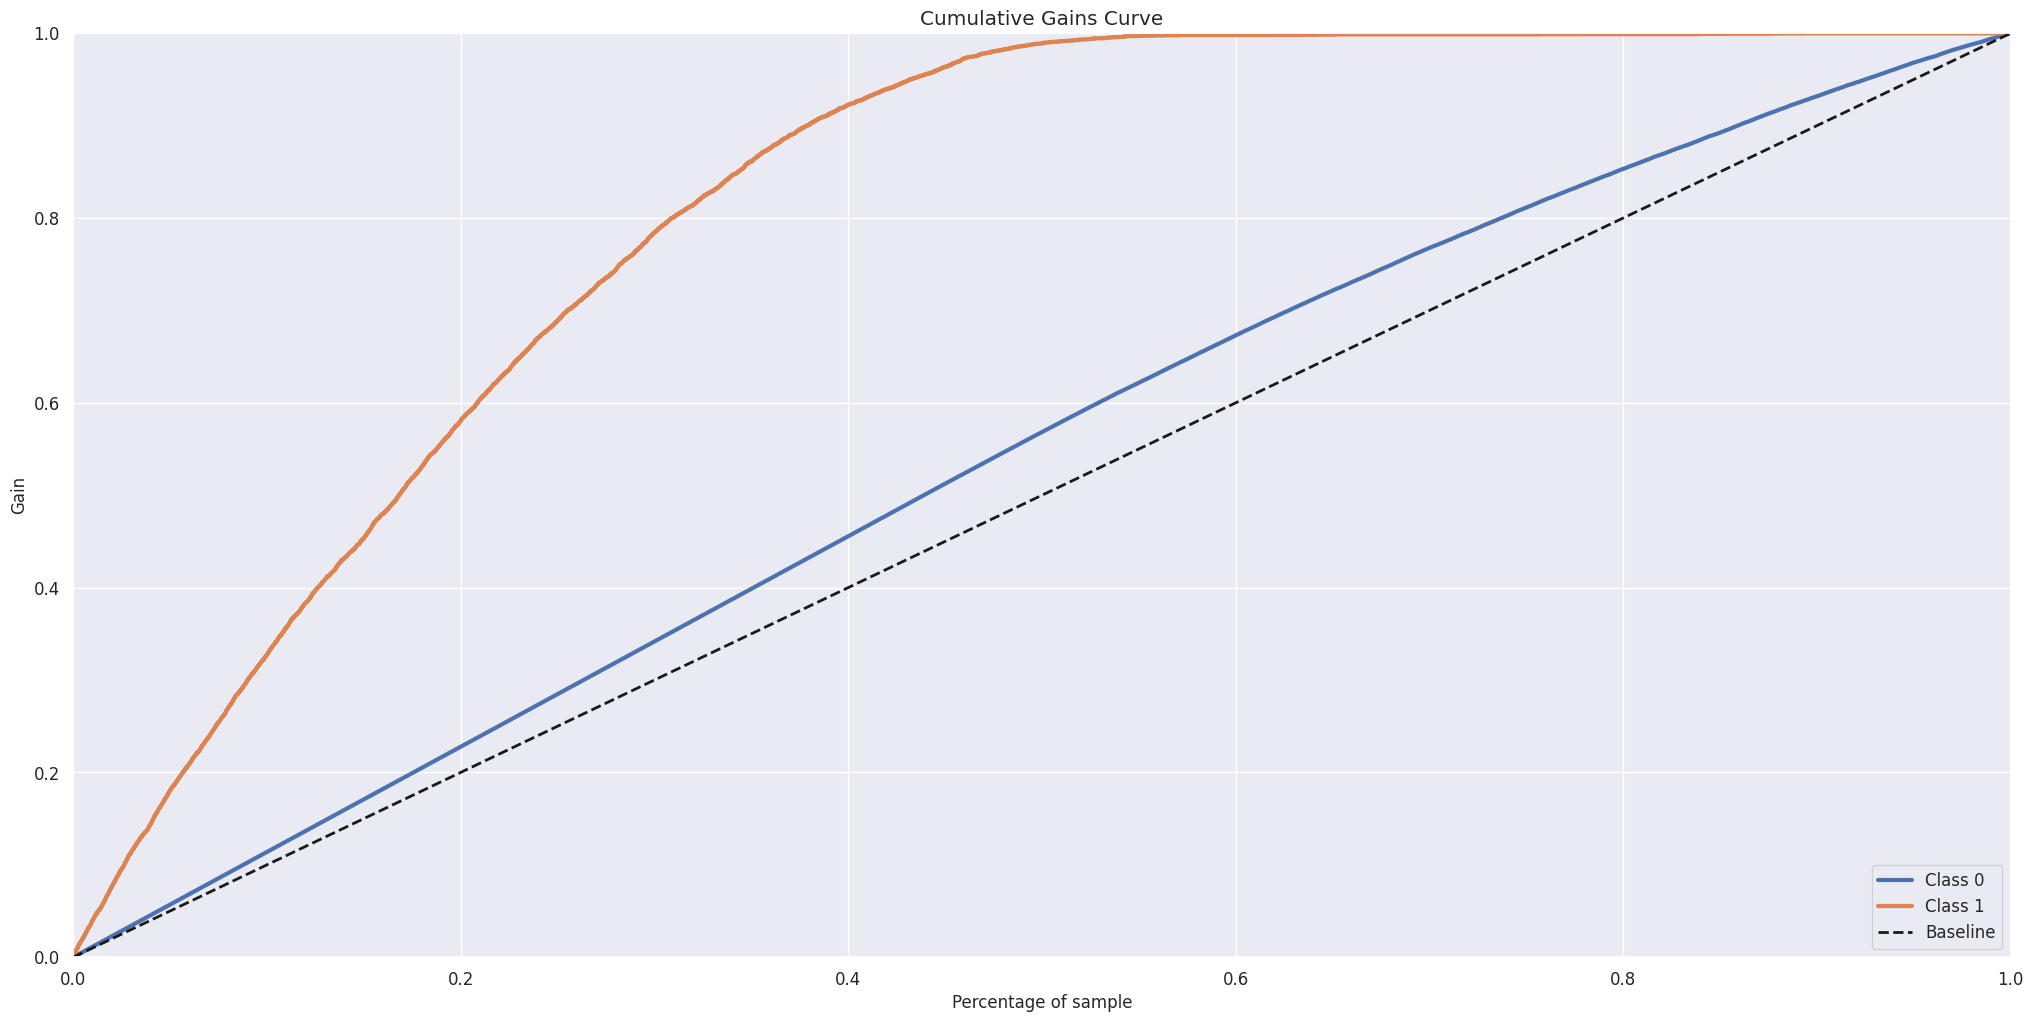

In [132]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lgbm_tunned)